# Problem Statement

Livable, a young home flipping firm, has interest in expanding the business to residences located in Ames. As part of the data science team in the company, I was tasked to analyse the historical data collected from 2006 to 2010 to predict house sale prices using Linear Regression Models. 

### Aims:
- Build a successful model that can accurately predict sale prices for the company to identify houses that are undervalued
- Use the model to identify key features that would direct decisions in renovations and repair works to increase profit yet ensure quality

### Evaluation Metrics:
1. RMSE (/RMSLE due to the log transformation on sale price)
    This metric will be used to determine the best model with the **lowest error** in predicting prices
2. R2 score
    This metric will be used to describe how well the model is able to predict prices. **Higher r2 score** would relate to a better model.

## Import libraries

In [121]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
# from seaborn_qqplot import pplot
import plotly.express as px

from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn import metrics

from scipy import stats
from scipy.stats import norm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [122]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

# Data Cleaning

In [123]:
# Load data sets
train_df = pd.read_csv('./datasets/train.csv', index_col='Id')
test_df = pd.read_csv('./datasets/test.csv', index_col='Id')

print(train_df.shape,test_df.shape)

(2051, 80) (878, 79)


In [124]:
# Reformat column names
train_df.columns = train_df.columns.str.lower().str.replace(' ','_')
test_df.columns = test_df.columns.str.lower().str.replace(' ','_')

In [125]:
# Check no missing y values
y = train_df.saleprice
y.isnull().sum()

0

Indeed, there are no missing house sale prices.

In [126]:
# Combine (i.e. concatenate) train and test set to clean the parameters together
combined_df = pd.concat([train_df, test_df], axis=0)
combined_df.shape

(2929, 80)

In [127]:
# Adding in data type column (mainly for personal reference; does not really help much)

data_type = {
             'pid': 'nominal',
            'ms_subclass': 'nominal','ms_zoning': 'nominal',
            'lot_frontage': 'continuous','lot_area': 'continuous',
            'street': 'nominal','alley': 'nominal',
            'lot_shape': 'ordinal','land_contour': 'nominal',
            'utilities': 'ordinal','lot_config': 'nominal','land_slope': 'ordinal',
            'neighborhood': 'nominal','condition_1': 'nominal','condition_2': 'nominal',
            'bldg_type': 'nominal','house_style': 'nominal',
            'overall_qual': 'ordinal','overall_cond': 'ordinal',
            'year_built': 'discrete','year_remod/add': 'discrete',
            'roof_style': 'nominal','roof_matl': 'nominal',
            'exterior_1': 'nominal','exterior_2': 'nominal',
            'mas_vnr_type': 'nominal','mas_vnr_area': 'continuous',
            'exter_qual': 'ordinal','exter_cond': 'ordinal',
            'foundation': 'nominal',
            'bsmt_qual': 'ordinal','bsmt_cond': 'ordinal','bsmt_exposure': 'ordinal',
            'bsmtfin_type_1': 'ordinal','bsmtfin_sf_1': 'continuous',
            'bsmtfin_type_2': 'ordinal','bsmtfin_sf_2': 'continuous',
            'bsmt_unf_sf': 'continuous','total_bsmt_sf': 'continuous',
            'heating': 'nominal','heatingqc': 'ordinal',
            'central_air': 'nominal','electrical': 'ordinal',
            '1st_flr_sf': 'continuous','2nd_flr_sf': 'continuous',
            'low_qual_fin_sf': 'continuous','gr_liv_area': 'continuous',
            'bsmt_full_bath': 'discrete','bsmt_half_bath': 'discrete',
            'full_bath': 'discrete','half_bath': 'discrete',
            'bedroom_abvgr':'discrete','kitchen_abvgr': 'discrete',
            'kitchen_qual': 'ordinal','totrms_abvgrd': 'discrete',
            'functional': 'ordinal',
            'fireplaces': 'discrete','fireplace_qu': 'ordinal',
            'garage_type': 'nominal','garage_yr_blt': 'discrete',
            'garage_finish': 'ordinal','garage_cars': 'discrete',
            'garage_area': 'continuous','garage_qual': 'ordinal','garage_cond': 'ordinal',
            'paved_drive': 'ordinal','wood_deck_sf': 'continuous',
            'open_porch_sf': 'continuous','enclosed_porch': 'continuous',
            '3ssn_porch': 'continuous','screen_porch': 'continuous',
            'pool_area': 'continuous','pool_qc': 'ordinal',
            'fence': 'ordinal','misc_feature': 'nominal','misc_val': 'continuous',
            'mo_sold': 'discrete','yr_sold': 'discrete',
            'sale_type': 'nominal','saleprice': 'continuous'
}

In [128]:
#identify null values
combined_df.isnull().sum().sort_values(ascending=False).head(30)

pool_qc           2916
misc_feature      2823
alley             2731
fence             2357
fireplace_qu      1422
saleprice          878
lot_frontage       490
garage_finish      159
garage_qual        159
garage_cond        159
garage_yr_blt      159
garage_type        157
bsmt_exposure       83
bsmtfin_type_2      81
bsmtfin_type_1      80
bsmt_cond           80
bsmt_qual           80
mas_vnr_area        23
mas_vnr_type        23
bsmt_full_bath       2
bsmt_half_bath       2
garage_cars          1
bsmtfin_sf_1         1
garage_area          1
bsmt_unf_sf          1
bsmtfin_sf_2         1
electrical           1
total_bsmt_sf        1
totrms_abvgrd        0
kitchen_qual         0
dtype: int64

In [129]:
s = combined_df.isnull().sum().sort_values(ascending=False).head(28)/len(combined_df)*100

In [130]:
missing_cols = pd.Series(s, name='percent_missing')
missing_cols.index.name = 'columns'
missing_cols = missing_cols.reset_index()
missing_cols['data_type'] = missing_cols['columns'].map(data_type)
# missing_cols = missing_cols.sort_values(by=['data_type'])
missing_cols

columns  percent_missing   data_type
0          pool_qc        99.556163     ordinal
1     misc_feature        96.381017     nominal
2            alley        93.240014     nominal
3            fence        80.471151     ordinal
4     fireplace_qu        48.548993     ordinal
5        saleprice        29.976101  continuous
6     lot_frontage        16.729259  continuous
7    garage_finish         5.428474     ordinal
8      garage_qual         5.428474     ordinal
9      garage_cond         5.428474     ordinal
10   garage_yr_blt         5.428474    discrete
11     garage_type         5.360191     nominal
12   bsmt_exposure         2.833732     ordinal
13  bsmtfin_type_2         2.765449     ordinal
14  bsmtfin_type_1         2.731308     ordinal
15       bsmt_cond         2.731308     ordinal
16       bsmt_qual         2.731308     ordinal
17    mas_vnr_area         0.785251  continuous
18    mas_vnr_type         0.785251     nominal
19  bsmt_full_bath         0.068283    discrete
20  bsmt_half_bath         0.068283    discrete
21     garage_cars         0.034141    discrete
22    bsmtfin_sf_1         0.034141  continuous
23     garage_area         0.034141  continuous
24     bsmt_unf_sf         0.034141  continuous
25    bsmtfin_sf_2         0.034141  continuous
26      electrical         0.034141     ordinal
27   total_bsmt_sf         0.034141  continuous

## Imputing Missing Values

I began by scrutinising the data documentation and available values in the dataset to determine the background of the missing values.

In [131]:
combined_df.describe().T

count          mean           std          min          25%  \
pid              2929.0  7.143984e+08  1.887291e+08  526301100.0  528477020.0   
ms_subclass      2929.0  5.738648e+01  4.264528e+01         20.0         20.0   
lot_frontage     2439.0  6.919967e+01  2.333768e+01         21.0         58.0   
lot_area         2929.0  1.013770e+04  7.861902e+03       1300.0       7440.0   
overall_qual     2929.0  6.093547e+00  1.409420e+00          1.0          5.0   
overall_cond     2929.0  5.563332e+00  1.111678e+00          1.0          5.0   
year_built       2929.0  1.971344e+03  3.024335e+01       1872.0       1954.0   
year_remod/add   2929.0  1.984258e+03  2.085924e+01       1950.0       1965.0   
mas_vnr_area     2906.0  1.016696e+02  1.787242e+02          0.0          0.0   
bsmtfin_sf_1     2928.0  4.420089e+02  4.544284e+02          0.0          0.0   
bsmtfin_sf_2     2928.0  4.973941e+01  1.691949e+02          0.0          0.0   
bsmt_unf_sf      2928.0  5.591537e+02  4.395297e+02          0.0        219.0   
total_bsmt_sf    2928.0  1.050902e+03  4.389992e+02          0.0        793.0   
1st_flr_sf       2929.0  1.158882e+03  3.902482e+02        334.0        876.0   
2nd_flr_sf       2929.0  3.350454e+02  4.278919e+02          0.0          0.0   
low_qual_fin_sf  2929.0  4.678389e+00  4.631834e+01          0.0          0.0   
gr_liv_area      2929.0  1.498606e+03  5.021749e+02        334.0       1126.0   
bsmt_full_bath   2927.0  4.311582e-01  5.248045e-01          0.0          0.0   
bsmt_half_bath   2927.0  6.115477e-02  2.452929e-01          0.0          0.0   
full_bath        2929.0  1.566064e+00  5.524000e-01          0.0          1.0   
half_bath        2929.0  3.793103e-01  5.025842e-01          0.0          0.0   
bedroom_abvgr    2929.0  2.854216e+00  8.278681e-01          0.0          2.0   
kitchen_abvgr    2929.0  1.044384e+00  2.141112e-01          0.0          1.0   
totrms_abvgrd    2929.0  6.441448e+00  1.570977e+00          2.0          5.0   
fireplaces       2929.0  5.991806e-01  6.479892e-01          0.0          0.0   
garage_yr_blt    2770.0  1.978122e+03  2.552712e+01       1895.0       1960.0   
garage_cars      2928.0  1.766393e+00  7.603546e-01          0.0          1.0   
garage_area      2928.0  4.726793e+02  2.149489e+02          0.0        320.0   
wood_deck_sf     2929.0  9.371287e+01  1.263655e+02          0.0          0.0   
open_porch_sf    2929.0  4.741106e+01  6.716892e+01          0.0          0.0   
enclosed_porch   2929.0  2.301946e+01  6.414860e+01          0.0          0.0   
3ssn_porch       2929.0  2.593377e+00  2.514558e+01          0.0          0.0   
screen_porch     2929.0  1.600751e+01  5.609617e+01          0.0          0.0   
pool_area        2929.0  2.244111e+00  3.560323e+01          0.0          0.0   
misc_val         2929.0  5.065244e+01  5.664402e+02          0.0          0.0   
mo_sold          2929.0  6.214749e+00  2.714055e+00          1.0          4.0   
yr_sold          2929.0  2.007791e+03  1.316757e+00       2006.0       2007.0   
saleprice        2051.0  1.814697e+05  7.925866e+04      12789.0     129825.0   

                         50%           75%           max  
pid              535453210.0  9.071811e+08  1.007100e+09  
ms_subclass             50.0  7.000000e+01  1.900000e+02  
lot_frontage            68.0  8.000000e+01  3.130000e+02  
lot_area              9434.0  1.155300e+04  2.152450e+05  
overall_qual             6.0  7.000000e+00  1.000000e+01  
overall_cond             5.0  6.000000e+00  9.000000e+00  
year_built            1973.0  2.001000e+03  2.010000e+03  
year_remod/add        1993.0  2.004000e+03  2.010000e+03  
mas_vnr_area             0.0  1.640000e+02  1.600000e+03  
bsmtfin_sf_1           370.0  7.340000e+02  5.644000e+03  
bsmtfin_sf_2             0.0  0.000000e+00  1.526000e+03  
bsmt_unf_sf            465.5  8.012500e+02  2.336000e+03  
total_bsmt_sf          990.0  1.300500e+03  6.110000e+03  
1st_flr_sf            1084.0  1.

In [132]:
# # Assumed to be lack of this house feature:
# combined_df['misc_feature'].value_counts()
# combined_df['alley'].value_counts()
# combined_df['fence'].value_counts()
# combined_df['mas_vnr_type'].value_counts() # therefore mas_vnr_area imputed with '0' 

In [133]:
# combined_df['pool_qc'].value_counts()
print(color.BOLD + 'Missing values for pool quality:'+ color.END)
print('Number of houses with zero pool area (i.e. no pool) = ' + str((combined_df['pool_area'] == 0).sum()))
print('Number of pool_qc for the cases with zero pool area = ' + str(((combined_df['pool_area'] == 0)&(combined_df['pool_qc'].isnull())).sum()))
print(color.BLUE + 'Impute missing with "None" as number matches the number of houses with no pool.'+ color.END)

Missing values for pool quality:
Number of houses with zero pool area (i.e. no pool) = 2916
Number of pool_qc for the cases with zero pool area = 2916
Impute missing with "None" as number matches the number of houses with no pool.


In [134]:
# print(combined_df['fireplace_qu'].value_counts())
print(color.BOLD + 'Missing values for fireplace quality:'+ color.END)
print('Number of houses with no fireplaces = ' + str((combined_df['fireplaces'] == 0).sum()))
print('Number of houses with missing fireplace quality = ' + str(combined_df['fireplace_qu'].isnull().sum()))
print(color.BLUE + 
      'Impute missing with "None" as missing fireplace quality cases matches the number of cases with no fireplaces.'
      + color.END)

Missing values for fireplace quality:
Number of houses with no fireplaces = 1422
Number of houses with missing fireplace quality = 1422
Impute missing with "None" as missing fireplace quality cases matches the number of cases with no fireplaces.


In [135]:
# print(combined_df['garage_type'].value_counts())
# print(combined_df['garage_finish'].value_counts())
# print(combined_df['garage_cond'].value_counts())
# print(combined_df['garage_qual'].value_counts())
# print(combined_df['mas_vnr_type'].value_counts())
print(color.BOLD + 'Missing values for garage features:'+ color.END)
print('Number of houses with no garage = ' + color.BOLD + str(combined_df['garage_type'].isnull().sum())+ color.END)
print('Number of houses with missing garage finish = ' + str(combined_df['garage_finish'].isnull().sum()))
print('Number of houses with missing garage condition = ' + str(combined_df['garage_cond'].isnull().sum()))
print('Number of houses with missing garage quality = ' + str(combined_df['garage_qual'].isnull().sum()))
print(color.BLUE + 'Impute missing with "None". Two extra missing garage features for houses which really have a garage but will impute with "None" since it is only 2 cases instead of dropping the row.'+ color.END)
print('Number of houses with missing garage year built = ' + str(combined_df['garage_yr_blt'].isnull().sum()))
print('Number of cases when garage was built in the same year as the house = ' + color.BOLD +
      str(combined_df.loc[combined_df['year_built'] == combined_df['garage_yr_blt']].shape[0]) + color.END + ' out of ' 
      + (color.BOLD + str(combined_df.shape[0]) + color.END))
print(color.BLUE + 'Impute missing with year house was built (mode choice).'+ color.END)

combined_df[['garage_type','garage_finish','garage_cond','garage_qual',
             'garage_cars','garage_area','garage_yr_blt','year_built']].loc[(combined_df['garage_type'].notnull()) & 
                                                               (
                                                                   (combined_df['garage_finish'].isnull()) | 
                                                                   (combined_df['garage_cond'].isnull()) | 
                                                                   (combined_df['garage_qual'].isnull()) | 
                                                                   (combined_df['garage_yr_blt'].isnull())
                                                               )]

Missing values for garage features:
Number of houses with no garage = 157
Number of houses with missing garage finish = 159
Number of houses with missing garage condition = 159
Number of houses with missing garage quality = 159
Impute missing with "None". Two extra missing garage features for houses which really have a garage but will impute with "None" since it is only 2 cases instead of dropping the row.
Number of houses with missing garage year built = 159
Number of cases when garage was built in the same year as the house = 2226 out of 2929
Impute missing with year house was built (mode choice).


garage_type garage_finish garage_cond garage_qual  garage_cars  \
Id                                                                    
2237      Detchd           NaN         NaN         NaN          NaN   
1357      Detchd           NaN         NaN         NaN          1.0   

      garage_area  garage_yr_blt  year_built  
Id                                            
2237          NaN            NaN        1923  
1357        360.0            NaN        1910

In [136]:
# combined_df['bsmt_cond'].value_counts()
# combined_df['bsmt_qual'].value_counts()
# combined_df['bsmt_exposure'].value_counts()
# combined_df['bsmtfin_type_1'].value_counts()
# combined_df['bsmtfin_type_2'].value_counts()
print()
print(color.BOLD + 'Missing values for basement features:'+ color.END)
print(color.BOLD + '80' + color.END + ' houses with no basement.')
print(color.BLUE + 'Impute missing with "None" for categorical data and "0" for numerical data.'+ color.END)
print()
print(color.BOLD + '3' + color.END + 
      ' basement exposure values and ' + color.BOLD + '1' + color.END + 
      ' finished basement type 2 rating were missing for houses with basements.')
print(color.BLUE + 'Impute missing with "None" as assumed to be number of missing values is not significant'+ color.END)

pd.set_option('display.max_rows', None)
combined_df[['bsmt_cond','bsmt_qual','bsmt_exposure','bsmtfin_type_1','bsmtfin_type_2',
             'total_bsmt_sf','bsmtfin_sf_1','bsmtfin_sf_2','bsmt_unf_sf']].loc[(combined_df['bsmt_exposure'].isnull())|
                                                                               (combined_df['bsmtfin_type_2'].isnull())]



Missing values for basement features:
80 houses with no basement.
Impute missing with "None" for categorical data and "0" for numerical data.

3 basement exposure values and 1 finished basement type 2 rating were missing for houses with basements.
Impute missing with "None" as assumed to be number of missing values is not significant


bsmt_cond bsmt_qual bsmt_exposure bsmtfin_type_1 bsmtfin_type_2  \
Id                                                                     
807        NaN       NaN           NaN            NaN            NaN   
811        NaN       NaN           NaN            NaN            NaN   
781        NaN       NaN           NaN            NaN            NaN   
888        NaN       NaN           NaN            NaN            NaN   
1554       NaN       NaN           NaN            NaN            NaN   
2740       NaN       NaN           NaN            NaN            NaN   
2242       NaN       NaN           NaN            NaN            NaN   
2745       NaN       NaN           NaN            NaN            NaN   
84         NaN       NaN           NaN            NaN            NaN   
1501       NaN       NaN           NaN            NaN            NaN   
155        NaN       NaN           NaN            NaN            NaN   
812        NaN       NaN           NaN            NaN            NaN   
2082       NaN       NaN           NaN            NaN            NaN   
1504       NaN       NaN           NaN            NaN            NaN   
946        NaN       NaN           NaN            NaN            NaN   
1498       NaN       NaN           NaN            NaN            NaN   
2904       NaN       NaN           NaN            NaN            NaN   
953        NaN       NaN           NaN            NaN            NaN   
274        NaN       NaN           NaN            NaN            NaN   
207        NaN       NaN           NaN            NaN            NaN   
788        NaN       NaN           NaN            NaN            NaN   
679        NaN       NaN           NaN            NaN            NaN   
1205       NaN       NaN           NaN            NaN            NaN   
1255       NaN       NaN           NaN            NaN            NaN   
677        NaN       NaN           NaN            NaN            NaN   
1375       NaN       NaN           NaN            NaN            NaN   
2622       NaN       NaN           NaN            NaN            NaN   
1880       NaN       NaN           NaN            NaN            NaN   
2703       NaN       NaN           NaN            NaN            NaN   
2177       NaN       NaN           NaN            NaN            NaN   
709        NaN       NaN           NaN            NaN            NaN   
1260       NaN       NaN           NaN            NaN            NaN   
2626       NaN       NaN           NaN            NaN            NaN   
445         TA        Gd            No            GLQ            NaN   
897        NaN       NaN           NaN            NaN            NaN   
2893       NaN       NaN           NaN            NaN            NaN   
1326       NaN       NaN           NaN            NaN            NaN   
244        NaN       NaN           NaN            NaN            NaN   
813        NaN       NaN           NaN            NaN            NaN   
1569       NaN       NaN           NaN            NaN            NaN   
1342       NaN       NaN           NaN            NaN            NaN   
650        NaN       NaN           NaN            NaN            NaN   
2707       NaN       NaN           NaN            NaN            NaN   
787        NaN       NaN           NaN            NaN            NaN   
1902       NaN       NaN           NaN            NaN            NaN   
1797        TA        Gd           NaN            Unf            Unf   
2701       NaN       NaN           NaN            NaN            NaN   
67          TA        Gd           NaN            Unf            Unf   
1502       NaN       NaN           NaN            NaN            NaN   
815        NaN       NaN           NaN            NaN            NaN   
1899       NaN       NaN           NaN            NaN            NaN   
2004       NaN       NaN           NaN            NaN            NaN   
2627       NaN       NaN           NaN            NaN            NaN   
2625       NaN       NaN           NaN       

### Notes:

After a comprehensive investigation on the features with missing values, the missing values will be imputed through 4 methods.

**Group 1:**
- Assumed/found to be a missing house feature
- Imputed with 'None'

**Group 2:**
- Assumed/found to be a numerical property of missing house feature
- Could also be cases where the feature did exist in the house but the data was not collected. As the numbers were small, the values were considered as negligible.
- Imputed with '0'

**Group 3:**
- House should have the feature but data missing
- Imputed with mode value

**Group 4:**
- Sizeable amount of missing numerical property of existing house feature
- Imputed with mean value

In [137]:
#Impute missing values
cleaned_combined = combined_df

from sklearn.impute import SimpleImputer
# Group 1: No feature
group_1 = [
    'pool_qc', 'misc_feature', 'alley', 'fence', 'fireplace_qu', 'garage_type',
    'garage_finish', 'garage_cond', 'garage_qual', 'mas_vnr_type',
    'bsmt_cond', 'bsmt_qual','bsmt_exposure', 'bsmtfin_type_1', 'bsmtfin_type_2'
]
cleaned_combined[group_1] = cleaned_combined[group_1].fillna("None")

# Group 2: Missing numerical data of non-exisiting feature or missing data of existing house feature but negligible
group_2 = [
    'garage_yr_blt', 'garage_cars', 'garage_area', 'bsmt_full_bath', 'bsmt_half_bath', 'mas_vnr_area',
    'total_bsmt_sf','bsmtfin_sf_1','bsmtfin_sf_2','bsmt_unf_sf'
]
cleaned_combined[group_2] = cleaned_combined[group_2].fillna(0)

# Group 3: Impute mode
group_3 = ['electrical'] #should have no NAs hence impute mode (actually only 1 missing value so quite insignificant)
imp_mode = SimpleImputer(strategy='most_frequent')
cleaned_combined[group_3] = pd.DataFrame(imp_mode.fit_transform(cleaned_combined[group_3]), index=cleaned_combined.index)

cleaned_combined.loc[(cleaned_combined['garage_yr_blt'] == 0) & (cleaned_combined['garage_type'] !=  'None'), 
                'garage_yr_blt'] = cleaned_combined['year_built']
cleaned_combined['garage_yr_blt'] = cleaned_combined['garage_yr_blt'].astype(int) # convert garage year built column to integers

# Group 4: Impute mean
# No missing lot area values and the min area != 0. Hence impute mean for this feature
cleaned_combined['lot_frontage'] = cleaned_combined['lot_frontage'].fillna(cleaned_combined['lot_frontage'].mean())

In [138]:
# Check that the missing values for garage_yr_blt were imputed successfully
print(cleaned_combined.loc[2237][['garage_yr_blt','year_built']])
print()
print(cleaned_combined.loc[1357][['garage_yr_blt','year_built']])

garage_yr_blt    1923
year_built       1923
Name: 2237, dtype: object

garage_yr_blt    1910
year_built       1910
Name: 1357, dtype: object


In [139]:
# Check that all missing values have been addressed
sum(cleaned_combined.loc[:, cleaned_combined.columns!='saleprice'].isnull().sum())

0

### Changing of datatype
Reasons: 
- Some numerical features are really categories.
- Some categorical features are gradings which can be converted to ordered numbers where possible

In [140]:
# Converting numerical features to categorical features
cleaned_combined = cleaned_combined.replace({"ms_subclass" : {20 : "SC20", 30 : "SC30", 40 : "SC40", 45 : "SC45", 
                                                              50 : "SC50", 60 : "SC60", 70 : "SC70", 75 : "SC75", 
                                                              80 : "SC80", 85 : "SC85", 90 : "SC90", 120 : "SC120", 
                                                              150 : "SC150", 160 : "SC160", 180 : "SC180", 
                                                              190 : "SC190"},
                                             
                                             "mo_sold" : {1 : "Jan", 2 : "Feb", 3 : "Mar", 4 : "Apr", 5 : "May", 
                                                         6 : "Jun", 7 : "Jul", 8 : "Aug", 9 : "Sep", 10 : "Oct",
                                                         11 : "Nov", 12 : "Dec"}
                                             })

In [141]:
# Converting categorical features to numerical features
cleaned_combined = cleaned_combined.replace({"alley" : {"None" : 0, "Grvl" : 1, "Pave" : 2},
                                             "bsmt_cond" : {"None" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                                             "bsmt_exposure" : {"None" : 0, "No" : 0, "Mn" : 1, "Av": 2, "Gd" : 3},
                                             "bsmtfin_type_1" : {"None" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                                                               "ALQ" : 5, "GLQ" : 6},
                                             "bsmtfin_type_2" : {"None" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                                                               "ALQ" : 5, "GLQ" : 6},
                                             "bsmt_qual" : {"None" : 0, "Po" : 1, "Fa" : 2, "TA": 3, "Gd" : 4, "Ex" : 5},
                                             "exter_cond" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                                             "exter_qual" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                                             "fireplace_qu" : {"None" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                                             "functional" : {"Sal" : 1, "Sev" : 2, "Maj2" : 3, "Maj1" : 4, "Mod": 5, 
                                                             "Min2" : 6, "Min1" : 7, "Typ" : 8},
                                             "garage_cond" : {"None" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                                             "garage_qual" : {"None" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                                             "heating_qc" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                                             "kitchen_qual" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                                             "land_slope" : {"Sev" : 1, "Mod" : 2, "Gtl" : 3},
                                             "lot_shape" : {"IR3" : 1, "IR2" : 2, "IR1" : 3, "Reg" : 4},
                                             "paved_drive" : {"N" : 0, "P" : 1, "Y" : 2},
                                             "pool_qc" : {"None" : 0, "Fa" : 1, "TA" : 2, "Gd" : 3, "Ex" : 4},
                                             "street" : {"Grvl" : 1, "Pave" : 2},
                                             "utilities" : {"ELO" : 1, "NoSeWa" : 2, "NoSewr" : 3, "AllPub" : 4}}
                                           )

### One-hot Encoding (for visualisation; not modelling set yet)

Reason for doing this now: To see correlations with categorical variables in EDA portion next. One-hot encoding for modelling would be done later after dealing with skewness and outliers.

In [142]:
catCols = list(cleaned_combined.select_dtypes(include='object').columns)
print(f"There are {len(catCols)} categorical features:\n", catCols)

There are 24 categorical features:
 ['ms_subclass', 'ms_zoning', 'land_contour', 'lot_config', 'neighborhood', 'condition_1', 'condition_2', 'bldg_type', 'house_style', 'roof_style', 'roof_matl', 'exterior_1st', 'exterior_2nd', 'mas_vnr_type', 'foundation', 'heating', 'central_air', 'electrical', 'garage_type', 'garage_finish', 'fence', 'misc_feature', 'mo_sold', 'sale_type']


In [143]:
catCols.append('saleprice')
cat_df = cleaned_combined[catCols]
cat_dummies = pd.get_dummies(cat_df, drop_first=True)
print("cat_dummies.shape:", cat_dummies.shape)

cat_dummies.shape: (2929, 182)


## Outliers

**[From Ames Housing Data Set Documentation]**

SPECIAL NOTES:\
"There are 5 observations that an instructor may wish to remove from the data set before giving it to students (***a plot of SALE PRICE versus GR LIV AREA will indicate them quickly***). Three of them are true outliers (Partial Sales that likely don’t represent actual market values) and two of them are simply unusual sales (very large houses priced relatively appropriately). I would recommend removing any houses with more than 4000 square feet from the data set (which eliminates these 5 unusual observations) before assigning it to students."

In [144]:
def plotCorrelation(variables):
    """
    1. Print correlation of two variables
    2. Create jointplot of two variables
    """
    # Print correlation
    print("Correlation: ", cleaned_combined[[variables[0],
                                             variables[1]]].corr().iloc[1, 0])

    # Create jointplot
    plt.figure(figsize=(6, 6))
    sns.jointplot(data=cleaned_combined,
                  x=cleaned_combined[(variables[0])],
                  y=cleaned_combined[(variables[1])],
                  kind='reg',
                  height=7,
                  color='CadetBlue',
                  scatter_kws={'s': 10},
                  marginal_kws={'kde': True})

Correlation:  0.6970384443056613


<Figure size 432x432 with 0 Axes>

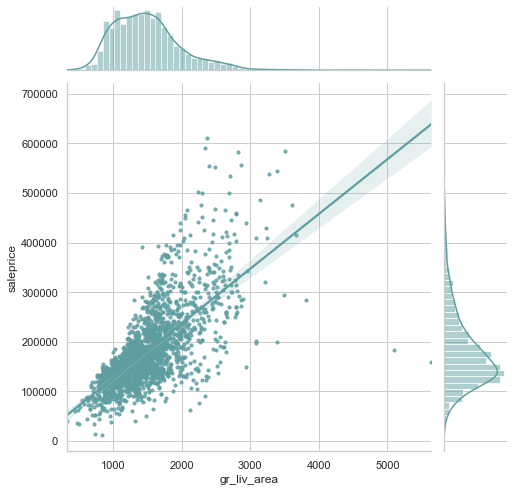

In [145]:
plotCorrelation(['gr_liv_area', 'saleprice'])

2 outliers observed - large living area but low prices. They will be deleted from the dataset.

In [146]:
# Identify and drop the 2 outliers
outlier_index = cleaned_combined[(cleaned_combined['gr_liv_area'] > 4000)
                           & (cleaned_combined.saleprice < 200000)].index
print(outlier_index)
cleaned_combined.drop(outlier_index, axis=0, inplace=True)

Int64Index([1499, 2181], dtype='int64', name='Id')


In [147]:
# Check years are in valid range
cleaned_combined[['yr_sold','year_built','year_remod/add','garage_yr_blt']].describe()

yr_sold   year_built  year_remod/add  garage_yr_blt
count  2927.000000  2927.000000     2927.000000    2927.000000
mean   2007.790912  1971.319098     1984.241886    1871.955928
std       1.317120    30.238491       20.856725     446.431559
min    2006.000000  1872.000000     1950.000000       0.000000
25%    2007.000000  1954.000000     1965.000000    1957.000000
50%    2008.000000  1973.000000     1993.000000    1977.000000
75%    2009.000000  2000.500000     2004.000000    2001.000000
max    2010.000000  2010.000000     2010.000000    2207.000000

In [148]:
cleaned_combined[['year_built','garage_type','garage_yr_blt']].loc[cleaned_combined['garage_yr_blt'] == 2207]

year_built garage_type  garage_yr_blt
Id                                         
2261        2006      Attchd           2207

In [149]:
# Impute with mode value
cleaned_combined.loc[(cleaned_combined['garage_yr_blt'] == 2207), 
                'garage_yr_blt'] = cleaned_combined['year_built']

# Check replacement was done correctly
print(cleaned_combined.loc[2261][['garage_yr_blt','year_built']])

garage_yr_blt    2006
year_built       2006
Name: 2261, dtype: object


# EDA
## Categorical features

In [150]:
print(list(catCols))

['ms_subclass', 'ms_zoning', 'land_contour', 'lot_config', 'neighborhood', 'condition_1', 'condition_2', 'bldg_type', 'house_style', 'roof_style', 'roof_matl', 'exterior_1st', 'exterior_2nd', 'mas_vnr_type', 'foundation', 'heating', 'central_air', 'electrical', 'garage_type', 'garage_finish', 'fence', 'misc_feature', 'mo_sold', 'sale_type', 'saleprice']


### Location

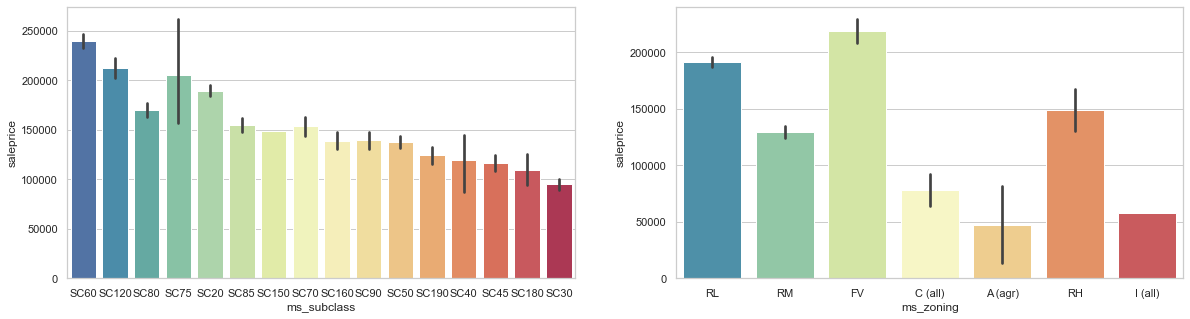

In [151]:
fig, ax =plt.subplots(1,2, figsize=(20, 5))
featOrder = cleaned_combined.groupby(['ms_subclass']).median().saleprice.sort_values(ascending=False).index
sns.barplot(x="ms_subclass", y="saleprice", data=cleaned_combined, palette="Spectral_r",ax=ax[0],order=featOrder)
sns.barplot(x="ms_zoning", y="saleprice", data=cleaned_combined, palette="Spectral_r",ax=ax[1]);

MS Subclass 60, 120 and 80 have the highest median sale price.\
More expensive houses are in Floating Village Residential and Residential Low Density zones while more affordable houses are in Agricultural, Industrial and Commerical zones.

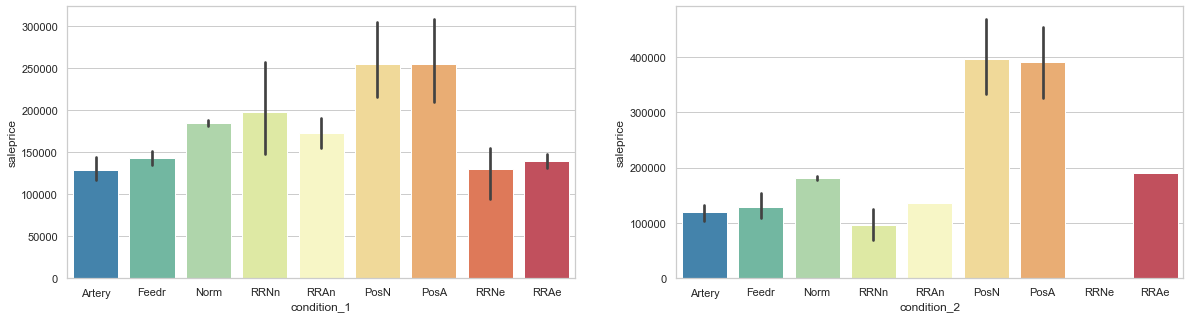

In [152]:
fig, ax =plt.subplots(1,2, figsize=(20, 5))
plot_order = ['Artery','Feedr','Norm','RRNn','RRAn','PosN','PosA','RRNe','RRAe']
sns.barplot(x="condition_1", y="saleprice", data=cleaned_combined, palette="Spectral_r",ax=ax[0],order=plot_order)
sns.barplot(x="condition_2", y="saleprice", data=cleaned_combined, palette="Spectral_r",ax=ax[1],order=plot_order);

Higher sale prices for houses near off-site features (parks, greenbelt, etc).
### Neighbourhoods

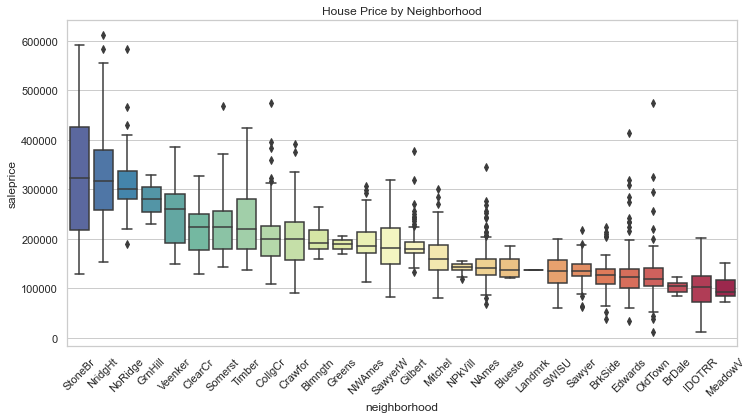

In [153]:
plt.figure(figsize=(12, 6))
featOrder = cleaned_combined.groupby(['neighborhood']).median().saleprice.sort_values(ascending=False).index
sns.boxplot(x='neighborhood',
            y='saleprice',
            data=cleaned_combined,
            order=featOrder,
            palette='Spectral_r')
title = plt.title('House Price by Neighborhood')
tick = plt.xticks(rotation=45)

Most expensive neighbourhoods: Northridge Heights, Northridge, Stone Brook \
Most affordable neighbourhoods:Briardale, Iowa DOT and Rail Road, Meadow Village 

The median price of houses in expensive neighbourhoods is around 3 times that of those in affordable neighbourhoods.
### House Exterior

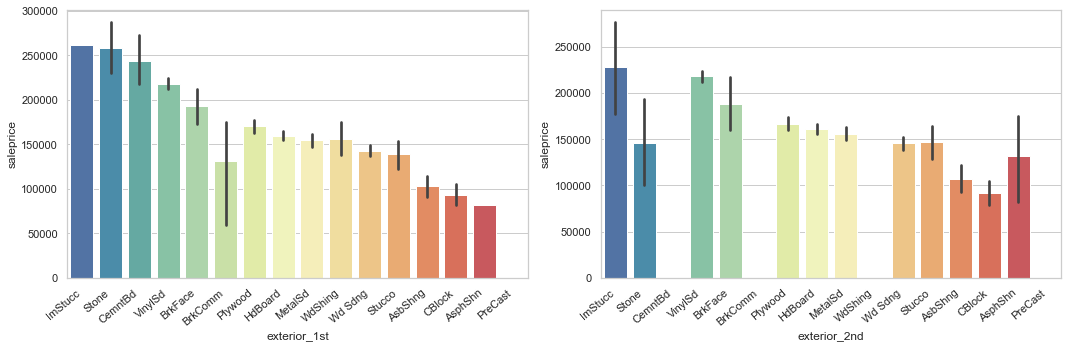

In [154]:
fig, ax =plt.subplots(1,2, figsize=(15, 5))
featOrder = cleaned_combined.groupby(['exterior_1st']).median().saleprice.sort_values(ascending=False).index
g1 = sns.barplot(x="exterior_1st", y="saleprice", data=cleaned_combined, palette="Spectral_r",ax=ax[0],order=featOrder)
g2 = sns.barplot(x="exterior_2nd", y="saleprice", data=cleaned_combined, palette="Spectral_r",ax=ax[1],order=featOrder)
g1.set_xticklabels(g1.get_xticklabels(), rotation=40, ha="right")
g2.set_xticklabels(g2.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show();

Higher sale prices for houses with Imitation Stucco, Stone and Cement Board exteriors.\
Lower sale prices for houses with Asbestos Shingles and Cinder Block exteriors.
### Roof style and materials

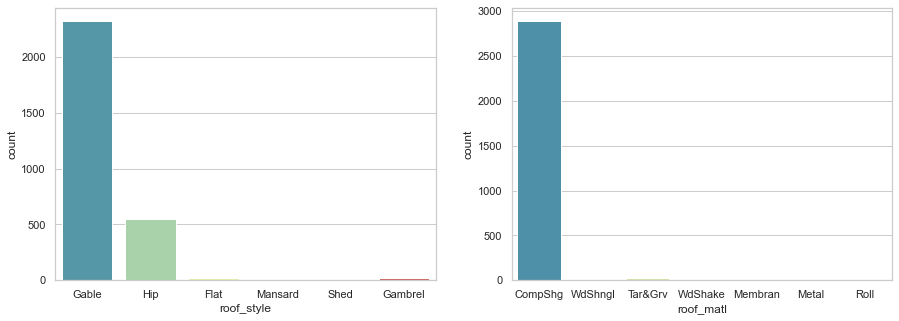

In [155]:
fig, ax =plt.subplots(1,2, figsize=(15, 5))
sns.countplot(data = cleaned_combined, x='roof_style', palette="Spectral_r",ax=ax[0])
sns.countplot(data = cleaned_combined, x='roof_matl', palette="Spectral_r", ax=ax[1]);

Most houses sold had Gable roof styles and most common material for roofs were Standard (Composite) Shingle.

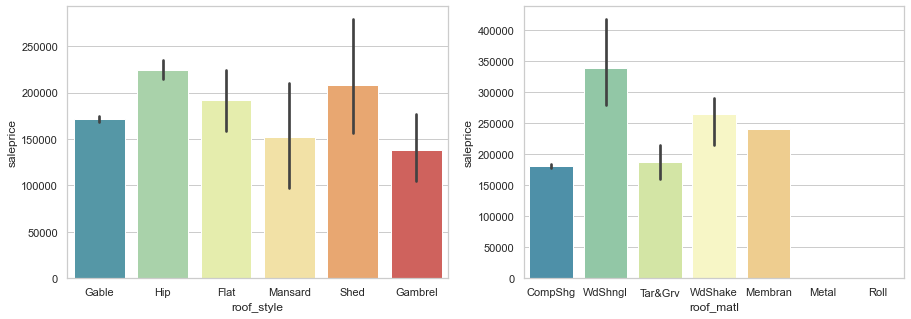

In [156]:
fig, ax =plt.subplots(1,2, figsize=(15, 5))
sns.barplot(x="roof_style", y="saleprice", data=cleaned_combined, palette="Spectral_r",ax=ax[0])
sns.barplot(x="roof_matl", y="saleprice", data=cleaned_combined, palette="Spectral_r",ax=ax[1]);

Houses with higher sale prices were those with Hip or Flat roof styles and Wood Shakes roof material.
### Garage

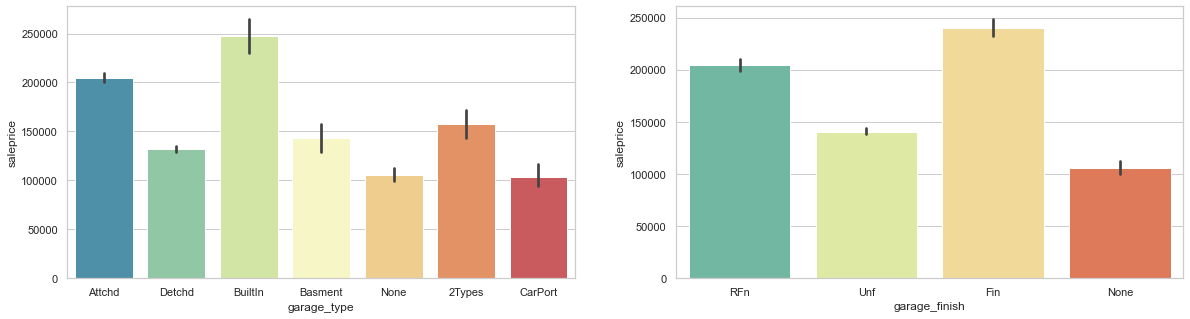

In [157]:
fig, ax =plt.subplots(1,2, figsize=(20, 5))
sns.barplot(x="garage_type", y="saleprice", data=cleaned_combined, palette="Spectral_r",ax=ax[0])
sns.barplot(x="garage_finish", y="saleprice", data=cleaned_combined, palette="Spectral_r",ax=ax[1]);

Finished garages would definitely boost sale price.
### Heating and Electrical

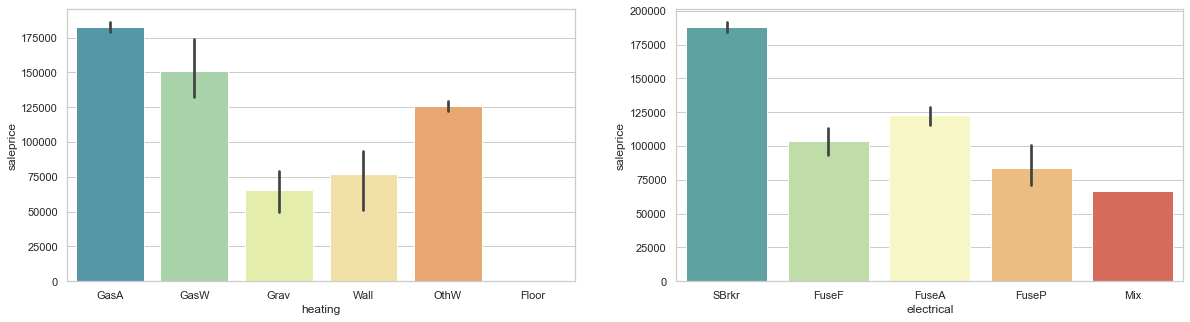

In [158]:
fig, ax =plt.subplots(1,2, figsize=(20, 5))
sns.barplot(x="heating", y="saleprice", data=cleaned_combined, palette="Spectral_r",ax=ax[0])
sns.barplot(x="electrical", y="saleprice", data=cleaned_combined, palette="Spectral_r",ax=ax[1]);

Common heating type is Gas forced warm air furnace and standard circuit breakers are the common electrical system for houses sold at higher prices.
### Peak periods for buying/selling houses

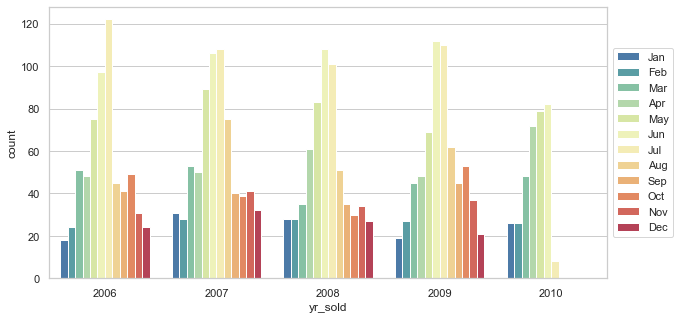

In [39]:
plt.figure(figsize=(10, 5))
hue_order = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
ax = sns.countplot(x="yr_sold", data=cleaned_combined, hue="mo_sold", hue_order=hue_order, palette="Spectral_r")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));

Popular months for when houses are sold is during summer (Jun-July). 

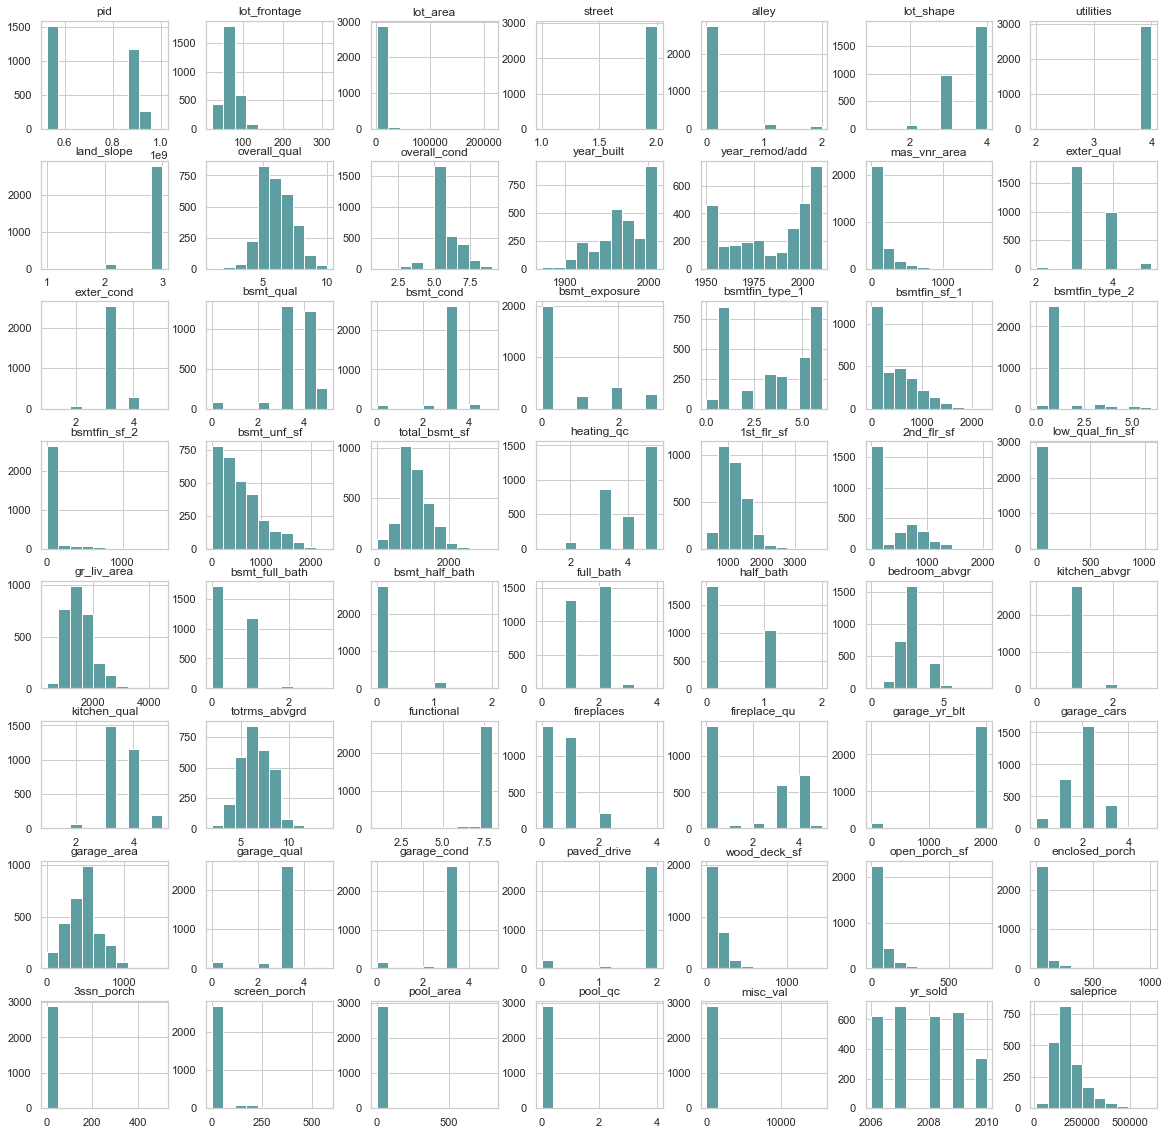

In [40]:
cleaned_combined.hist(figsize=(20, 20),color='CadetBlue');

Many numerical features are skewed. A log-transformation would help them lean towards a normal distribution.
## Correlation with Sale Price

In [41]:
# For internal reference of data type
corr_saleprice = cleaned_combined.corr()[['saleprice']].sort_values('saleprice', ascending=False)
corr_saleprice.index.name = 'columns'
corr_saleprice = corr_saleprice.reset_index()
corr_saleprice['data_type'] = corr_saleprice['columns'].map(data_type)
corr_saleprice

columns  saleprice   data_type
0         saleprice   1.000000  continuous
1      overall_qual   0.803462     ordinal
2       gr_liv_area   0.719463  continuous
3        exter_qual   0.715048     ordinal
4      kitchen_qual   0.694295     ordinal
5     total_bsmt_sf   0.665116  continuous
6       garage_area   0.655097  continuous
7        1st_flr_sf   0.648252  continuous
8       garage_cars   0.648227    discrete
9         bsmt_qual   0.613236     ordinal
10       year_built   0.572405    discrete
11   year_remod/add   0.550872    discrete
12     fireplace_qu   0.539484     ordinal
13        full_bath   0.538225    discrete
14     mas_vnr_area   0.511273  continuous
15    totrms_abvgrd   0.509775    discrete
16       fireplaces   0.473783    discrete
17       heating_qc   0.458636         NaN
18     bsmtfin_sf_1   0.446103  continuous
19    bsmt_exposure   0.414689     ordinal
20   bsmtfin_type_1   0.350728     ordinal
21     lot_frontage   0.339101  continuous
22    open_porch_sf   0.338545  continuous
23     wood_deck_sf   0.327629  continuous
24         lot_area   0.303744  continuous
25      paved_drive   0.290528     ordinal
26      garage_qual   0.285328     ordinal
27   bsmt_full_bath   0.284433    discrete
28        half_bath   0.283372    discrete
29      garage_cond   0.265066     ordinal
30    garage_yr_blt   0.258766    discrete
31       2nd_flr_sf   0.248826  continuous
32        bsmt_cond   0.225096     ordinal
33      bsmt_unf_sf   0.190883  continuous
34    bedroom_abvgr   0.137145    discrete
35     screen_porch   0.134555  continuous
36       functional   0.125714     ordinal
37           street   0.069850     nominal
38       3ssn_porch   0.048721  continuous
39       exter_cond   0.036393     ordinal
40          pool_qc   0.035535     ordinal
41        utilities   0.026408     ordinal
42        pool_area   0.025805  continuous
43     bsmtfin_sf_2   0.016398  continuous
44   bsmtfin_type_2   0.014037     ordinal
45         misc_val  -0.010323  continuous
46          yr_sold  -0.015174    discrete
47  low_qual_fin_sf  -0.041608  continuous
48   bsmt_half_bath  -0.045534    discrete
49       land_slope  -0.057967     ordinal
50     overall_cond  -0.097093     ordinal
51            alley  -0.097450     nominal
52    kitchen_abvgr  -0.125472    discrete
53   enclosed_porch  -0.135713  continuous
54              pid  -0.255068     nominal
55        lot_shape  -0.296743     ordinal

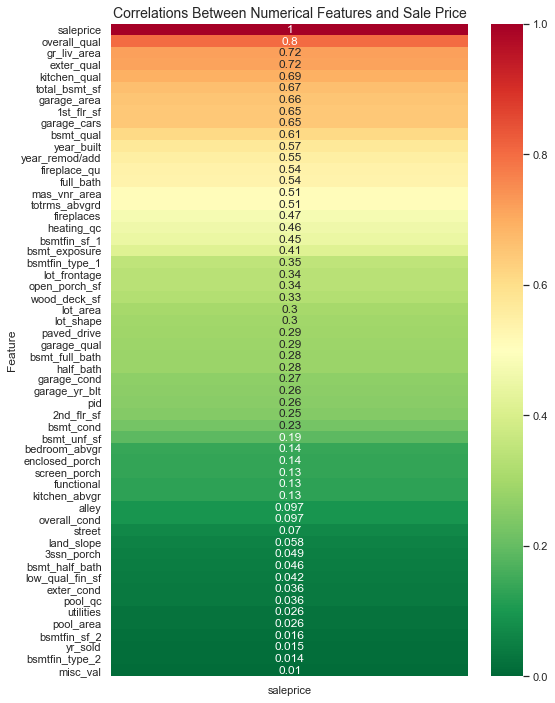

In [42]:
corr_saleprice_mat = cleaned_combined.corr().abs()[['saleprice']].sort_values('saleprice', ascending=False)
plt.figure(figsize=(8, 12))
sns.heatmap(corr_saleprice_mat, annot = True, vmin = 0, vmax = 1, cmap = 'RdYlGn_r')
plt.title('Correlations Between Numerical Features and Sale Price', fontdict={'fontsize':14})
plt.ylabel('Feature');

In [43]:
corr_saleprice_mat = cat_dummies.corr().abs()[['saleprice']].sort_values('saleprice', ascending=False)
narr_corr_saleprice_mat = corr_saleprice_mat.loc[corr_saleprice_mat['saleprice'] > 0.2]

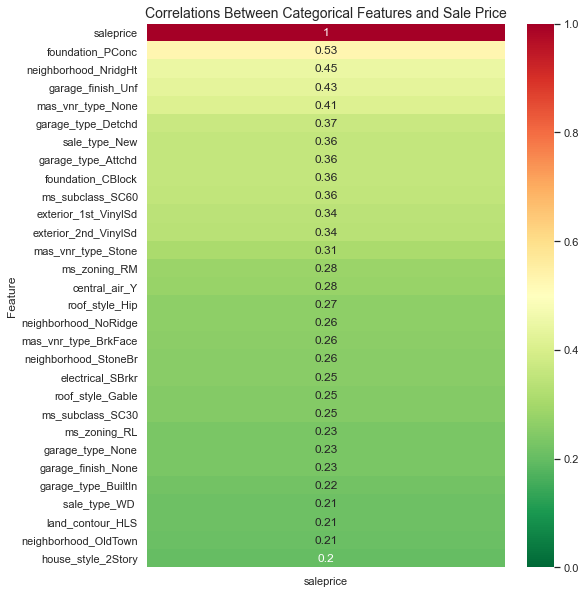

In [44]:
plt.figure(figsize=(8, 10))
sns.heatmap(narr_corr_saleprice_mat, annot = True, vmin = 0, vmax = 1, cmap = 'RdYlGn_r')
plt.title('Correlations Between Categorical Features and Sale Price', fontdict={'fontsize':14})
plt.ylabel('Feature');

## Collinearity

> "A key goal of regression analysis is to isolate the relationship between each independent variable and the dependent variable. The interpretation of a regression coefficient is that it represents the mean change in the dependent variable for each 1 unit change in an independent variable when you hold all of the other independent variables constant." ([Link](https://statisticsbyjim.com/regression/multicollinearity-in-regression-analysis/))

### Collinearity Check on Numerical Features 

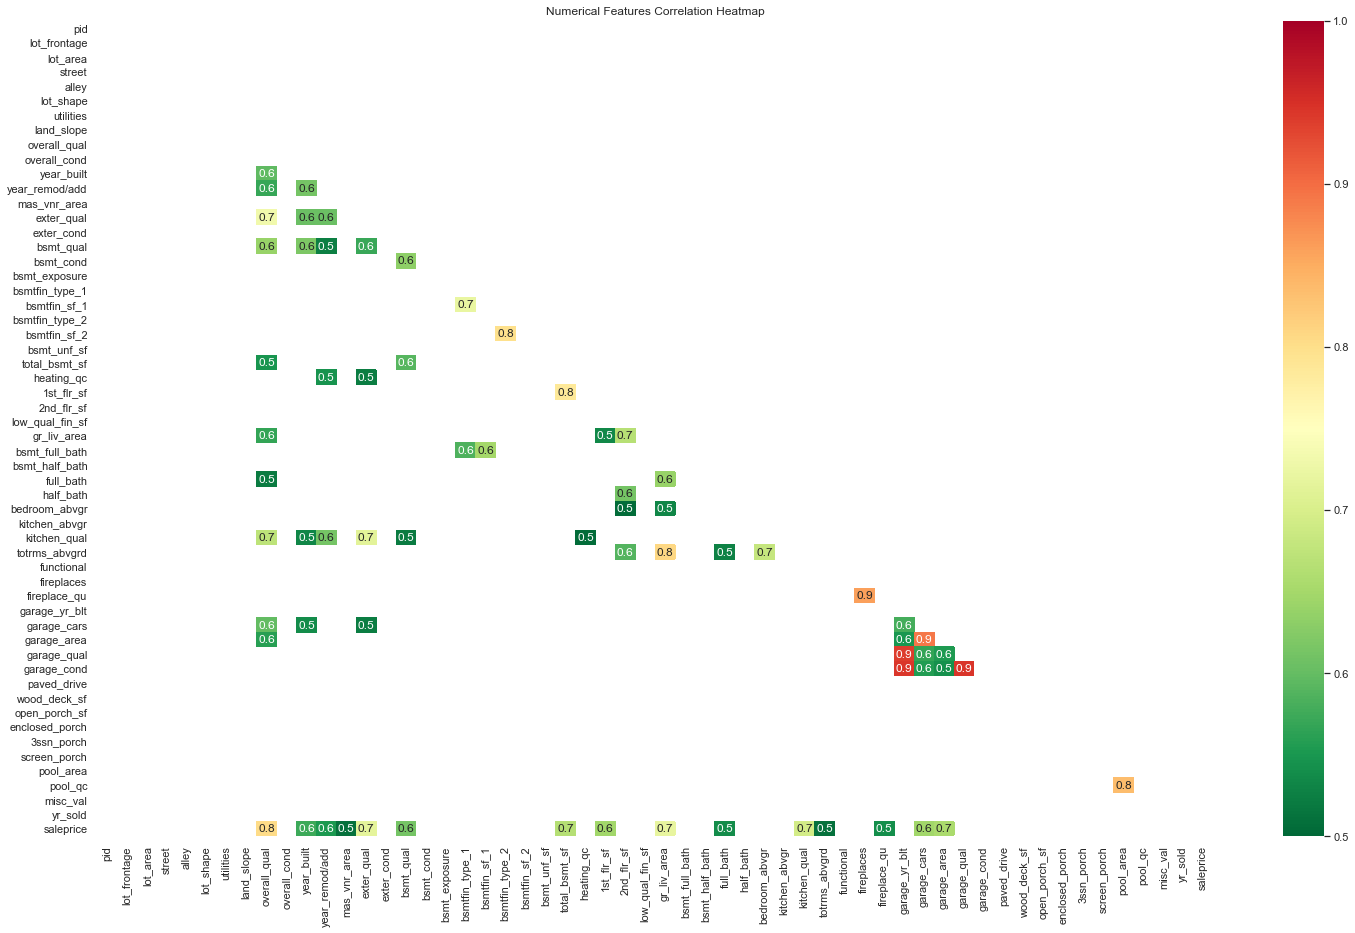

In [45]:
# Create correlation matrix to observe numerical features
corr_mat = cleaned_combined.corr()

# Select correlations greater than 0.5
high_corr_mat = corr_mat[abs(corr_mat) >= 0.5]

# Mask upper triangle
mask = np.zeros_like(corr_mat)
mask[np.triu_indices_from(mask)] = True

# Plot correlation heatmap
plt.figure(figsize=(25, 15))
sns.heatmap(high_corr_mat,
            mask = mask,
            annot=True,
            fmt='.1f',
            cmap='RdYlGn_r',
            vmin=0.5,
            vmax=1)
title = plt.title('Numerical Features Correlation Heatmap')

Plot above is rather tiny. Will identify highly correlated variables and replot.

In [46]:
# Further narrow the displayed features in the corr matrix
narrowed_mat = corr_mat[(abs(corr_mat) >= 0.5) & (corr_mat < 1)]

(narrowed_mat.loc[:, narrowed_mat.any()]).columns

Index(['overall_qual', 'year_built', 'year_remod/add', 'mas_vnr_area',
       'exter_qual', 'bsmt_qual', 'bsmt_cond', 'bsmtfin_type_1',
       'bsmtfin_sf_1', 'bsmtfin_type_2', 'bsmtfin_sf_2', 'total_bsmt_sf',
       'heating_qc', '1st_flr_sf', '2nd_flr_sf', 'gr_liv_area',
       'bsmt_full_bath', 'full_bath', 'half_bath', 'bedroom_abvgr',
       'kitchen_qual', 'totrms_abvgrd', 'fireplaces', 'fireplace_qu',
       'garage_yr_blt', 'garage_cars', 'garage_area', 'garage_qual',
       'garage_cond', 'pool_area', 'pool_qc', 'saleprice'],
      dtype='object')

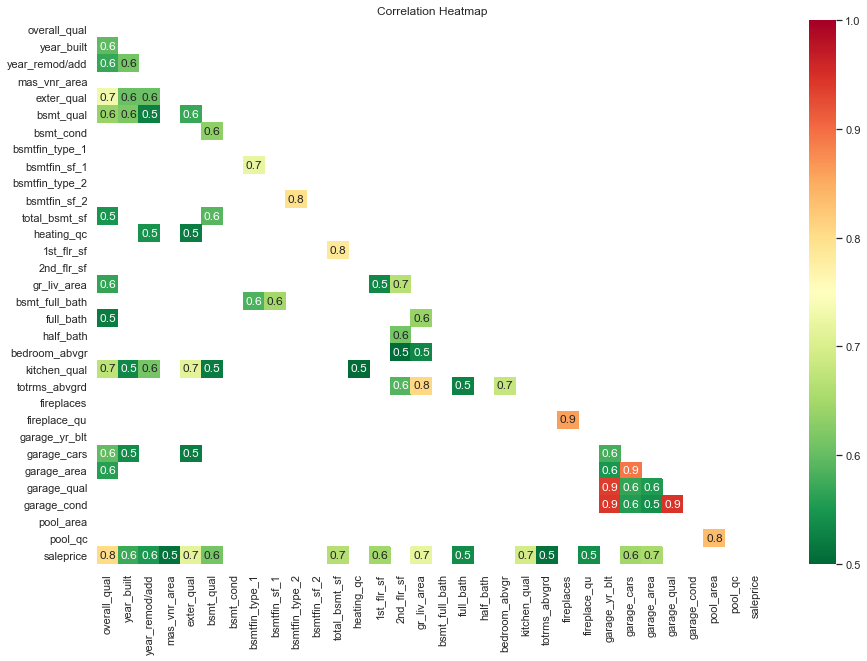

In [47]:
# Create narrowed down correlation matrix
corr_mat = cleaned_combined[['overall_qual', 'year_built', 'year_remod/add', 'mas_vnr_area',
       'exter_qual', 'bsmt_qual', 'bsmt_cond', 'bsmtfin_type_1',
       'bsmtfin_sf_1', 'bsmtfin_type_2', 'bsmtfin_sf_2', 'total_bsmt_sf',
       'heating_qc', '1st_flr_sf', '2nd_flr_sf', 'gr_liv_area',
       'bsmt_full_bath', 'full_bath', 'half_bath', 'bedroom_abvgr',
       'kitchen_qual', 'totrms_abvgrd', 'fireplaces', 'fireplace_qu',
       'garage_yr_blt', 'garage_cars', 'garage_area', 'garage_qual',
       'garage_cond', 'pool_area', 'pool_qc', 'saleprice']].corr()

# Select correlations greater than 0.5
high_corr_mat = corr_mat[abs(corr_mat) >= 0.5]

# Mask upper triangle
mask = np.zeros_like(corr_mat)
mask[np.triu_indices_from(mask)] = True

# Plot correlation heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(high_corr_mat,
            mask = mask,
            annot=True,
            fmt='.1f',
            cmap='RdYlGn_r',
            vmin=0.5,
            vmax=1)
title = plt.title('Correlation Heatmap')

In [48]:
num_corr_mat = cleaned_combined.corr().abs()
num_corr_list = num_corr_mat.unstack().sort_values(kind="quicksort", ascending=False)
num_corr_list = pd.Series(num_corr_list, name='correlation')
num_corr_list.index.name = 'columns'
num_corr_list = num_corr_list.reset_index()
num_corr_list = pd.merge(num_corr_list, corr_saleprice[['columns','saleprice']], 
                         left_on = 'level_0', right_on = 'columns', how = 'left')
num_corr_list = num_corr_list.drop(columns=['columns'])
num_corr_list= num_corr_list.rename(columns = {'level_0':'feature_1', 'level_1':'feature_2',
                                'correlation':'correlation_between_feature_1_&_2', 
                                'saleprice':'correlation_between_feature_1_&_saleprice'})
high_coll = num_corr_list.loc[(num_corr_list['correlation_between_feature_1_&_2'] > 0.5) &
                  (num_corr_list['correlation_between_feature_1_&_2'] < 1)]
high_coll

feature_1       feature_2  correlation_between_feature_1_&_2  \
56      garage_cond     garage_qual                           0.946667   
57      garage_qual     garage_cond                           0.946667   
58      garage_cond   garage_yr_blt                           0.943742   
59    garage_yr_blt     garage_cond                           0.943742   
60    garage_yr_blt     garage_qual                           0.938636   
61      garage_qual   garage_yr_blt                           0.938636   
62      garage_cars     garage_area                           0.892446   
63      garage_area     garage_cars                           0.892446   
64       fireplaces    fireplace_qu                           0.860846   
65     fireplace_qu      fireplaces                           0.860846   
66          pool_qc       pool_area                           0.835103   
67        pool_area         pool_qc                           0.835103   
68    totrms_abvgrd     gr_liv_area                           0.807220   
69      gr_liv_area   totrms_abvgrd                           0.807220   
70        saleprice    overall_qual                           0.803462   
71     overall_qual       saleprice                           0.803462   
72     bsmtfin_sf_2  bsmtfin_type_2                           0.797586   
73   bsmtfin_type_2    bsmtfin_sf_2                           0.797586   
74       1st_flr_sf   total_bsmt_sf                           0.785267   
75    total_bsmt_sf      1st_flr_sf                           0.785267   
76       exter_qual    overall_qual                           0.732220   
77     overall_qual      exter_qual                           0.732220   
78   bsmtfin_type_1    bsmtfin_sf_1                           0.721068   
79     bsmtfin_sf_1  bsmtfin_type_1                           0.721068   
80        saleprice     gr_liv_area                           0.719463   
81      gr_liv_area       saleprice                           0.719463   
82       exter_qual       saleprice                           0.715048   
83        saleprice      exter_qual                           0.715048   
84       exter_qual    kitchen_qual                           0.714071   
85     kitchen_qual      exter_qual                           0.714071   
86     kitchen_qual       saleprice                           0.694295   
87        saleprice    kitchen_qual                           0.694295   
88    totrms_abvgrd   bedroom_abvgr                           0.680199   
89    bedroom_abvgr   totrms_abvgrd                           0.680199   
90     overall_qual    kitchen_qual                           0.673321   
91     kitchen_qual    overall_qual                           0.673321   
92       2nd_flr_sf     gr_liv_area                           0.666428   
93      gr_liv_area      2nd_flr_sf                           0.666428   
94        saleprice   total_bsmt_sf                           0.665116   
95    total_bsmt_sf       saleprice                           0.665116   
96        saleprice     garage_area                           0.655097   
97      garage_area       saleprice                           0.655097   
98   bsmt_full_bath    bsmtfin_sf_1                           0.648811   
99     bsmtfin_sf_1  bsmt_full_bath                           0.648811   
100      1st_flr_sf       saleprice                           0.648252   
101       saleprice      1st_flr_sf                           0.648252   
102     garage_cars       saleprice                           0.648227   
103       saleprice     garage_cars                           0.648227   
104       bsmt_qual    overall_qual                           0.640539   
105    overall_qual       bsmt_qual                           0.640539   
106       full_bath     gr_liv_area                           0.638898   
107     gr_liv_area       full_bath                           0.638898   
108       bsmt_qual       bsmt_cond                           0.631760   
109       bsmt

There are multiple highly correlated features (57 pairs with pearson correlation coefficient > 0.5 or VIF >5).

Multicollinearity will be addressed via (i) feature engineering (ii) centering (under robust scaling) and (iii) regularisation regression models.

## Feature Engineering

In [49]:
cleaned_combined.shape

(2927, 80)

In [50]:
# Visualise relationship of sale price with overall condition

px.scatter(cleaned_combined, x="overall_cond", y="saleprice",
           color="overall_qual", title="House Price by Overall Condition",
           labels={"overall_cond": "Overall Condition of the House",
                   "overall_qual": "Overall Quality",
                   "saleprice": "Sale Price",
                     },
          color_continuous_scale='portland',
          template='simple_white')

In [51]:
cleaned_combined["simpl_overall_cond"] = cleaned_combined.overall_cond.replace({1 : 1, 2 : 1, 3 : 1, 4 : 1, # bad; below average
                                                                                5 : 2, 6 : 2, 7 : 2, # average and above
                                                                                8 : 2, 9 : 2, 10 : 2
                                                                               })

In [52]:
cleaned_combined['overall_state'] = cleaned_combined['overall_qual']*cleaned_combined['simpl_overall_cond']
cleaned_combined['prev_overall_state'] = cleaned_combined['overall_qual']*cleaned_combined['overall_cond']

In [53]:
cleaned_combined[['overall_qual','overall_cond','simpl_overall_cond','prev_overall_state','overall_state','saleprice']].corr()

overall_qual  overall_cond  simpl_overall_cond  \
overall_qual            1.000000     -0.093755            0.279219   
overall_cond           -0.093755      1.000000            0.467299   
simpl_overall_cond      0.279219      0.467299            1.000000   
prev_overall_state      0.726590      0.595484            0.484486   
overall_state           0.942977      0.067282            0.569488   
saleprice               0.803462     -0.097093            0.234425   

                    prev_overall_state  overall_state  saleprice  
overall_qual                  0.726590       0.942977   0.803462  
overall_cond                  0.595484       0.067282  -0.097093  
simpl_overall_cond            0.484486       0.569488   0.234425  
prev_overall_state            1.000000       0.780752   0.566299  
overall_state                 0.780752       1.000000   0.769211  
saleprice                     0.566299       0.769211   1.000000

Combining overall quality and condition might have seemed like a good idea, however, the overall condition of the house is not linearly related with the sale price (pearson's coefficient of -0.097, practically a horizontal line!). This suggests that the overall condition is not a good feature to predict sale prices in a linear regression model and combining it with other features would not really benefit the modelling.

Simplifying the overall condition feature could increase its correlation with saleprice and combined feature of overall quality.

Nonetheless, our company would not resell houses in any condition worse than average hence it is safe to simplify the feature into 2 categories.

In [54]:
# exterior state
cleaned_combined['exterior_state'] = cleaned_combined['exter_qual']*cleaned_combined['exter_cond']

# bsmt state
cleaned_combined['bsmt_state'] = cleaned_combined['bsmt_qual']*cleaned_combined['bsmt_cond']

# pool
cleaned_combined['pool_state'] = cleaned_combined['pool_area']*cleaned_combined['pool_qc']

In [55]:
cleaned_combined[['exter_qual','exter_cond','exterior_state',
                  'bsmt_qual','bsmt_cond','bsmt_state',
                  'pool_area','pool_qc','pool_state','saleprice']].corr()

exter_qual  exter_cond  exterior_state  bsmt_qual  bsmt_cond  \
exter_qual        1.000000    0.029797        0.829010   0.571283   0.187422   
exter_cond        0.029797    1.000000        0.574004  -0.021688   0.120785   
exterior_state    0.829010    0.574004        1.000000   0.441607   0.215751   
bsmt_qual         0.571283   -0.021688        0.441607   1.000000   0.631760   
bsmt_cond         0.187422    0.120785        0.215751   0.631760   1.000000   
bsmt_state        0.562445    0.025793        0.463703   0.942357   0.735365   
pool_area         0.012025   -0.001876        0.009592  -0.009956  -0.020963   
pool_qc           0.040310    0.005742        0.037440   0.010502  -0.010889   
pool_state        0.028170    0.004720        0.026964   0.002472  -0.013194   
saleprice         0.715048    0.036393        0.598104   0.613236   0.225096   

                bsmt_state  pool_area   pool_qc  pool_state  saleprice  
exter_qual        0.562445   0.012025  0.040310    0.028170   0.715048  
exter_cond        0.025793  -0.001876  0.005742    0.004720   0.036393  
exterior_state    0.463703   0.009592  0.037440    0.026964   0.598104  
bsmt_qual         0.942357  -0.009956  0.010502    0.002472   0.613236  
bsmt_cond         0.735365  -0.020963 -0.010889   -0.013194   0.225096  
bsmt_state        1.000000  -0.010023  0.008206    0.001111   0.601286  
pool_area        -0.010023   1.000000  0.835103    0.933253   0.025805  
pool_qc           0.008206   0.835103  1.000000    0.910939   0.035535  
pool_state        0.001111   0.933253  0.910939    1.000000   0.030869  
saleprice         0.601286   0.025805  0.035535    0.030869   1.000000

In [56]:
# Create new feature if house underwent remodelling
# Ensure year_remod/add is either same as year built or later
cleaned_combined[['year_remod/add','year_built']].loc[cleaned_combined['year_remod/add'] < cleaned_combined['year_built']]

year_remod/add  year_built
Id                             
851            2001        2002

In [57]:
# Replace remod/add year with year built (assumed to have not been remodelled)
cleaned_combined.at[851,'year_remod/add']=2002
cleaned_combined.loc[851][['year_remod/add','year_built']]

year_remod/add    2002
year_built        2002
Name: 851, dtype: object

In [58]:
# New features:
# overall_state (shown above)
# exterior_state (shown above)
# bsmt_state (shown above)
# pool_state (shown above)

# overall age
cleaned_combined['house_age'] = cleaned_combined['yr_sold'] - cleaned_combined['year_built']

# underwent remodelling?
cleaned_combined['remodelled'] = np.where(cleaned_combined['year_remod/add'] == cleaned_combined['year_built'], 0, 1)

# sold when it was new?
cleaned_combined['is_new'] = np.where(cleaned_combined['yr_sold'] == cleaned_combined['year_built'], 1, 0)

# overall size
cleaned_combined['total_sf'] = (cleaned_combined['total_bsmt_sf'] + cleaned_combined['1st_flr_sf'] 
                                + cleaned_combined['2nd_flr_sf'])

# basement area
cleaned_combined['bsmt_fin_area_1'] = cleaned_combined['bsmtfin_type_1']*cleaned_combined['bsmtfin_sf_1']
cleaned_combined['bsmt_fin_area_2'] = cleaned_combined['bsmtfin_type_2']*cleaned_combined['bsmtfin_sf_2']

# no. of baths
cleaned_combined['total_baths'] = (cleaned_combined['bsmt_full_bath'] + cleaned_combined['full_bath'] 
                                   + 0.5*(cleaned_combined['bsmt_half_bath'] +cleaned_combined['half_bath']))

# kitchen score
cleaned_combined['kitchen'] = cleaned_combined['kitchen_abvgr'] * cleaned_combined['kitchen_qual']

# fireplace score
cleaned_combined['fireplace'] = cleaned_combined['fireplaces'] * cleaned_combined['fireplace_qu']

# garage state
cleaned_combined['garage_state'] = cleaned_combined['garage_qual'] * cleaned_combined['garage_cond']

# garage age 
cleaned_combined['garage_age'] = cleaned_combined['yr_sold'] - cleaned_combined['garage_yr_blt']

# garage size
cleaned_combined['garage_size_per_car'] = cleaned_combined['garage_area'] / cleaned_combined['garage_cars']
cleaned_combined['garage_size_per_car'] = cleaned_combined['garage_size_per_car'].fillna(0)

# drop variables 
cleaned_combined.drop(['overall_cond','prev_overall_state','simpl_overall_cond','garage_area', 'garage_cars',
                       'year_built','year_remod/add','garage_yr_blt','pool_qc','pool_area','exter_cond','bsmt_cond',
                       'total_bsmt_sf','1st_flr_sf','2nd_flr_sf','fireplaces','fireplace_qu',
                       'bsmtfin_type_1','bsmtfin_sf_1','bsmtfin_type_2','bsmtfin_sf_2',
                       'kitchen_qual','kitchen_abvgr','garage_qual','garage_cond'], axis=1, inplace=True)

In [59]:
cleaned_combined.shape

(2927, 73)

**Notes:**
Unsure if garage size should be included in the overall house area. I have excluded it for now.

Dropped variables with high correlation to each other or very low correlation with sale price (e.g. pool, conditions) to fix multicollinearity and reduce noise.

Kept quality columns despite high correlation as they seemed rather important to drop

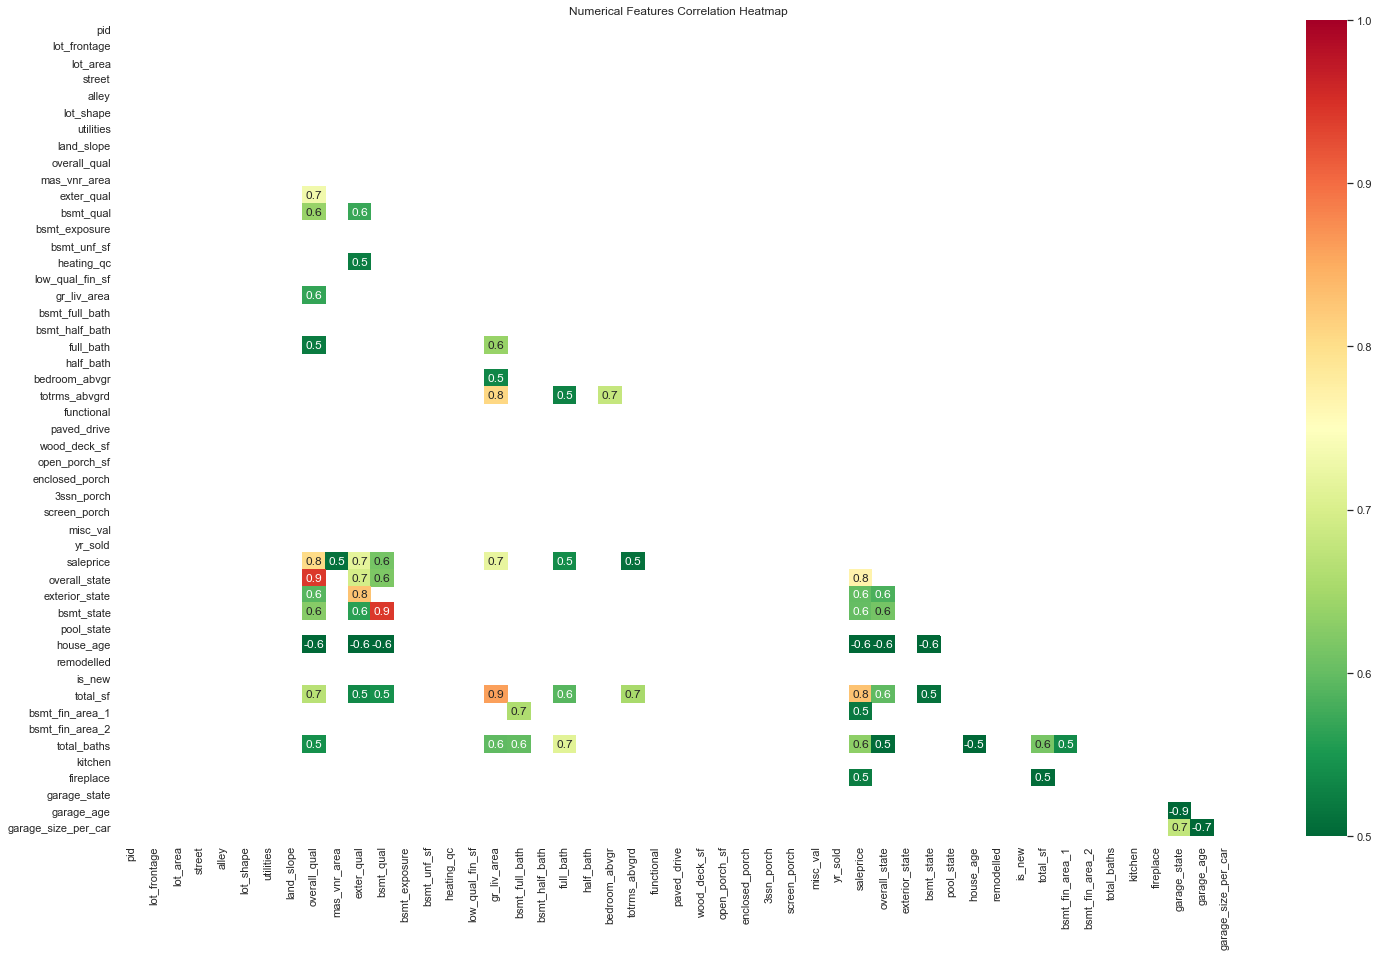

In [60]:
# Relook at updated correlations
# Create correlation matrix to observe numerical features
corr_mat = cleaned_combined.corr()

# Select correlations greater than 0.5
high_corr_mat = corr_mat[abs(corr_mat) >= 0.5]

# Mask upper triangle
mask = np.zeros_like(corr_mat)
mask[np.triu_indices_from(mask)] = True

# Plot correlation heatmap
plt.figure(figsize=(25, 15))
sns.heatmap(high_corr_mat,
            mask = mask,
            annot=True,
            fmt='.1f',
            cmap='RdYlGn_r',
            vmin=0.5,
            vmax=1)
title = plt.title('Numerical Features Correlation Heatmap')

## Skewness and Normalising Variables

STATS RESEARCH

There are **four assumptions** associated with a **linear regression model**: ([Link](https://sphweb.bumc.bu.edu/otlt/MPH-Modules/BS/R/R5_Correlation-Regression/R5_Correlation-Regression4.html))
1. Linearity: The relationship between X and the mean of Y is linear.
2. Homoscedasticity: The variance of residual is the same for any value of X.
3. Independence: Observations are independent of each other.
4. Normality: For any fixed value of X, Y is normally distributed.

Therefore, transfoming skewed data will help the models perform better.

**Understanding Skewness and Kurtosis** ([Read more here!](https://www.analyticsvidhya.com/blog/2021/05/shape-of-data-skewness-and-kurtosis/))

“Skewness essentially measures the symmetry of the distribution, while kurtosis determines the heaviness of the distribution tails.”

***Skewness***
><span style="color:maroon">1. Positive skewed or right-skewed</span>\
    Mean > Median > Mode\
    For positively skewed distributions, the famous transformation is the log transformation.
    
><span style="color:maroon">2. Negative skewed or left-skewed</span>\
    Mode > Median > Mean
    
>If the skewness is between -0.5 & 0.5, the data are nearly symmetrical.\
If the skewness is between -1 & -0.5 (negative skewed) or between 0.5 & 1(positive skewed), the data are slightly skewed.\
If the skewness is lower than -1 (negative skewed) or greater than 1 (positive skewed), the data are extremely skewed.


***Kurtosis*** *refers to the degree of presence of outliers in the distribution.* 
>Kurtosis of a normal distrubution is **3**.\
If kurtosis < 3, data set has lighter tails than a normal distribution, or lack of outliers.\
If kurtosis > 3, data set has heavier tails than a normal distribution, or more chance of outliers.

When data is skewed, the tail region may behave as an outlier for the statistical model, and outliers unsympathetically affect the model’s performance especially regression-based models. 

In [61]:
ntest = len(test_df)
y = cleaned_combined.iloc[:-ntest, :]
y = y.saleprice
y.shape

(2049,)

In [62]:
def normality_plot(X):
    """
    1. Draw distribution plot with normal distribution fitted curve (blue line)
    2. Draw Quantile-Quantile plot 
    """
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    ax = sns.histplot(X, stat='density', kde=True, color='CadetBlue',ax=axes[0])
    mu, std = stats.norm.fit(X)
    xx = np.linspace(*ax.get_xlim(),100)
    ax.plot(xx, stats.norm.pdf(xx, mu, std),color='black');
    axes[0].set_title("Distribution Plot")
    
    axes[1] = stats.probplot((X), plot=plt) # Unfortunately, not able to figure out how to change the qq plot colours
    plt.tight_layout()

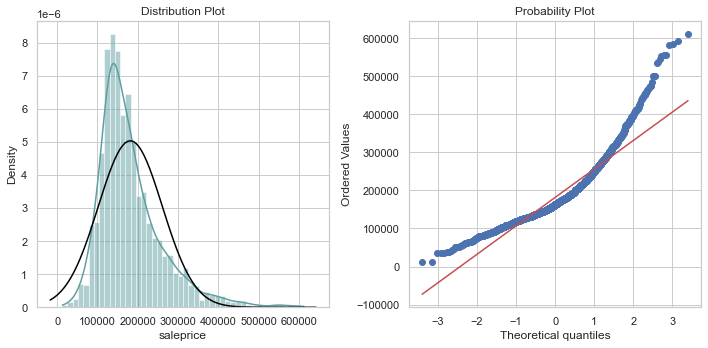

In [63]:
normality_plot(y)

In [64]:
print(f"""Skewness: {y.skew()}
Kurtosis: {y.kurt()}
Mean: {y.mean()}
Median: {y.median()}
Mode: {(y.mode())[0]}""")

Skewness: 1.5565344779493424
Kurtosis: 3.5723362303394097
Mean: 181479.01805758907
Median: 162500.0
Mode: 130000.0


Sale Price is **right-skewed**. I will perform a **log transformation** to pull larger values to the center.

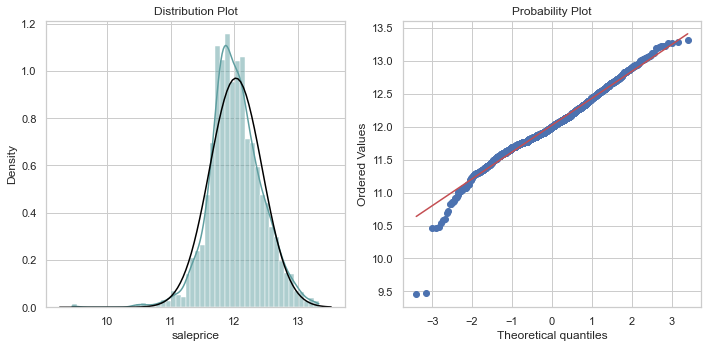

In [65]:
y = np.log(y)
normality_plot(y)

The new y is closer to a normal distribution after the log transformation. 

Next, I will examine skewness in the rest of the numerical variables and log transform those with skewness **> 0.5**. As there are several numerical variables with min value 0, I will use **log(1+X)** to fix skewness as log(0) would result in error. This would save time from having to sift out the ordinal variables or continuous data with 0s.

In [66]:
skew_kurt = pd.concat([cleaned_combined.skew(),cleaned_combined.kurt()], axis = 1)
skew_kurt= skew_kurt.rename(columns = {0:'skew', 1:'kurt'})
skew_kurt.index.name = 'columns'
skew_kurt = skew_kurt.reset_index()
skew_kurt['data_type'] = skew_kurt['columns'].map(data_type)
skew_kurt['min'] = skew_kurt['columns'].map(cleaned_combined.min())
skew_kurt

columns       skew         kurt   data_type        min
0                   pid   0.057997    -1.994904     nominal  526301100
1          lot_frontage   1.224151     9.429272  continuous       21.0
2              lot_area  13.185490   278.287802  continuous       1300
3                street -15.529583   239.331471     nominal          1
4                 alley   4.147123    16.738643     nominal          0
5             lot_shape  -1.236812     1.444067     ordinal          1
6             utilities -36.790182  1461.220196     ordinal          2
7            land_slope  -4.985318    26.660538     ordinal          1
8          overall_qual   0.179374     0.038687     ordinal          1
9          mas_vnr_area   2.600195     9.295327  continuous        0.0
10           exter_qual   0.773042     0.044096     ordinal          2
11            bsmt_qual  -1.272077     4.049380     ordinal          0
12        bsmt_exposure   1.232373    -0.042861     ordinal          0
13          bsmt_unf_sf   0.924561     0.411962  continuous        0.0
14           heating_qc  -0.542842    -1.157032         NaN          1
15      low_qual_fin_sf  12.111843   175.423094  continuous          0
16          gr_liv_area   0.976593     1.700488  continuous        334
17       bsmt_full_bath   0.616245    -0.755784    discrete        0.0
18       bsmt_half_bath   3.954525    15.042990    discrete        0.0
19            full_bath   0.170533    -0.545364    discrete          0
20            half_bath   0.700861    -1.025033    discrete          0
21        bedroom_abvgr   0.305389     1.889507    discrete          0
22        totrms_abvgrd   0.704940     0.918873    discrete          2
23           functional  -5.171810    30.517608     ordinal          1
24          paved_drive  -2.985981     7.158401     ordinal          0
25         wood_deck_sf   1.844800     6.798068  continuous          0
26        open_porch_sf   2.495253    10.836814  continuous          0
27       enclosed_porch   4.012130    28.457395  continuous          0
28           3ssn_porch  11.397832   149.830828  continuous          0
29         screen_porch   3.955084    17.836664  continuous          0
30             misc_val  22.232593   609.273441  continuous          0
31              yr_sold   0.133924    -1.158806    discrete       2006
32            saleprice   1.556534     3.572336  continuous    12789.0
33        overall_state  -0.322185     0.452991         NaN          1
34       exterior_state   0.777401     2.854584         NaN          2
35           bsmt_state  -0.737619     2.802801         NaN          0
36           pool_state  20.228980   436.917561         NaN          0
37            house_age   0.602487    -0.493682         NaN          0
38           remodelled   0.144625    -1.980437         NaN          0
39               is_new   4.768571    20.753449         NaN          0
40             total_sf   0.734449     1.275465         NaN      334.0
41      bsmt_fin_area_1   1.204858     1.029952         NaN        0.0
42      bsmt_fin_area_2   5.522399    36.968423         NaN        0.0
43          total_baths   0.488818     0.955958         NaN        1.0
44              kitchen   1.128762     3.011598         NaN          0
45            fireplace   0.917300     0.581700         NaN          0
46         garage_state  -2.384425     9.285295         NaN          0
47           garage_age   3.944337    13.625400         NaN          0
48  garage_size_per_car  -0.392652     6.259131         NaN        0.0

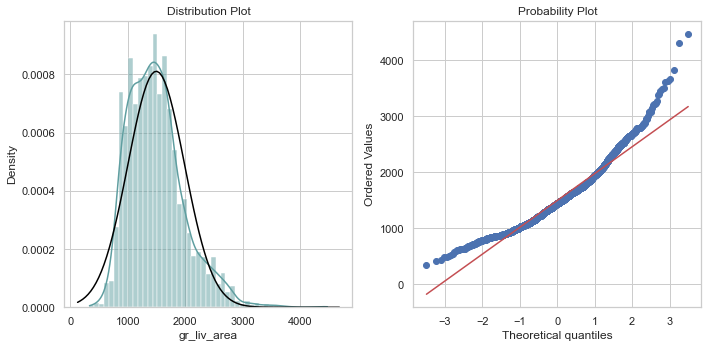

In [67]:
normality_plot(cleaned_combined['gr_liv_area'])

In [68]:
skewness = cleaned_combined.skew().sort_values(ascending=False)

# List of skewed columns
skewed_cols = list(skewness[abs(skewness) > 0.5].index)

# Remove 'MSSubClass' and 'saleprice'
skewed_cols = [
    col for col in skewed_cols if col not in ['saleprice']
]

# Log-transform skewed columns
for col in skewed_cols:
    cleaned_combined[col] = np.log(1 + cleaned_combined[col])

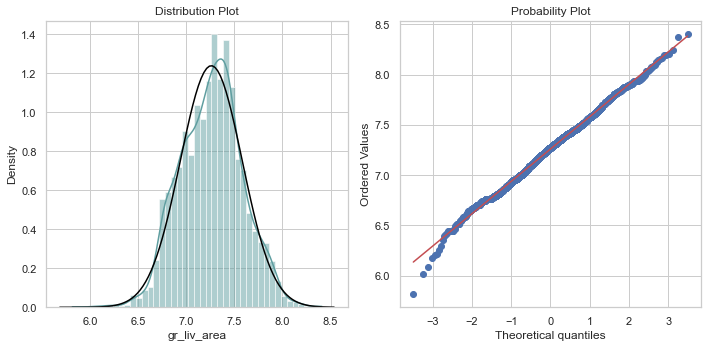

In [69]:
normality_plot(cleaned_combined['gr_liv_area'])

# Preprocessing
## One-hot Encoding of categorical features & Scaling of numerical features

In [70]:
# Drop sale price from X
cleaned_combined = cleaned_combined.drop(['saleprice'], axis=1)
cleaned_combined.shape

(2927, 72)

In [71]:
numCols = list(cleaned_combined.select_dtypes(exclude='object').columns)
print(f"There are {len(numCols)} numerical features:\n", numCols)

There are 48 numerical features:
 ['pid', 'lot_frontage', 'lot_area', 'street', 'alley', 'lot_shape', 'utilities', 'land_slope', 'overall_qual', 'mas_vnr_area', 'exter_qual', 'bsmt_qual', 'bsmt_exposure', 'bsmt_unf_sf', 'heating_qc', 'low_qual_fin_sf', 'gr_liv_area', 'bsmt_full_bath', 'bsmt_half_bath', 'full_bath', 'half_bath', 'bedroom_abvgr', 'totrms_abvgrd', 'functional', 'paved_drive', 'wood_deck_sf', 'open_porch_sf', 'enclosed_porch', '3ssn_porch', 'screen_porch', 'misc_val', 'yr_sold', 'overall_state', 'exterior_state', 'bsmt_state', 'pool_state', 'house_age', 'remodelled', 'is_new', 'total_sf', 'bsmt_fin_area_1', 'bsmt_fin_area_2', 'total_baths', 'kitchen', 'fireplace', 'garage_state', 'garage_age', 'garage_size_per_car']


In [72]:
# This would turn the dataframe to numpy.ndarray and harder to manipulate

# # Define which columns should be encoded vs scaled
# columns_to_encode = catCols
# columns_to_scale  = numCols

# # Instantiate encoder/scaler
# scaler = StandardScaler()
# ohe    = OneHotEncoder(sparse=False)

# # Scale and Encode Separate Columns
# scaled_columns  = scaler.fit_transform(cleaned_combined[columns_to_scale]) 
# encoded_columns =    ohe.fit_transform(cleaned_combined[columns_to_encode])

# # Concatenate (Column-Bind) Processed Columns Back Together
# processed_data = np.concatenate([scaled_columns, encoded_columns], axis=1)

**sklearn.preprocessing.RobustScaler** [Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html)

Scale features using statistics that are robust to outliers.

This Scaler removes the median and scales the data according to the quantile range (defaults to IQR: Interquartile Range). The IQR is the range between the 1st quartile (25th quantile) and the 3rd quartile (75th quantile).

Centering and scaling happen independently on each feature by computing the relevant statistics on the samples in the training set. Median and interquartile range are then stored to be used on later data using the transform method.

Standardization of a dataset is a common requirement for many machine learning estimators. Typically this is done by removing the mean and scaling to unit variance. However, outliers can often influence the sample mean / variance in a negative way. In such cases, the median and the interquartile range often give better results.

>Sklearn Scalers include centering which would also help with multicollinearity.

In [73]:
numCols = list(cleaned_combined.select_dtypes(exclude=['object']).columns)
scaler = RobustScaler()
cleaned_combined[numCols] = scaler.fit_transform(cleaned_combined[numCols])
type(cleaned_combined)

pandas.core.frame.DataFrame

In [74]:
cleaned_combined = pd.get_dummies(cleaned_combined, drop_first=True)
print("cleaned_combined.shape:", cleaned_combined.shape)

cleaned_combined.shape: (2927, 227)


### Re-splitting into train and test sets

In [75]:
Z_train = cleaned_combined.iloc[:-ntest, :]
Z_test = cleaned_combined.iloc[-ntest:, :]
print("Z_train.shape:", Z_train.shape)
print("Z_test.shape:", Z_test.shape)

Z_train.shape: (2049, 227)
Z_test.shape: (878, 227)


# Modelling
### Functions

In [76]:
def display_R2_scores(model, X_train, y_train, X_test, y_test):
    print(f'The mean cross validation score for this model is {round(cross_val_score(model, X_train, y_train, cv=5).mean(),4)}.')
    print(f'The training score for this model is {round(model.score(X_train, y_train), 4)}.')
    print(f'The testing score for this model is {round(model.score(X_test, y_test),4)}.')

In [77]:
# Instead of using train-test split for the regularisation models, 
# they will be evaluated using cross-validation (5-fold) 
# so that the data can be trained using 5 different sets of train and test data. 
# RMSLE is used because of the log transformation on y

n_folds = 5


def getRMSLE(model):
    """
    Return the average RMSLE over all folds of training data.
    """
    # Set KFold to shuffle data before the split
    kf = KFold(n_folds, shuffle=True, random_state=42)

    # Get RMSLE score
    rmlse = np.sqrt(-cross_val_score(
        model, Z_train, y, scoring="neg_mean_squared_error", cv=kf))

    return rmlse.mean()

### Train-test split on train dataset itself

In [78]:
X_train_80, X_test_20, y_train_80, y_test_20 = train_test_split(Z_train, y, train_size=0.8, random_state=42)
print('X_train size: ' + str(X_train_80.shape))
print('y_train size: ' + str(y_train_80.shape))
print('X_test size: ' + str(X_test_20.shape))
print('y_test size: ' + str(y_test_20.shape))

X_train size: (1639, 227)
y_train size: (1639,)
X_test size: (410, 227)
y_test size: (410,)


## Null Model

In [79]:
dr = DummyRegressor() #default is mean

In [80]:
dr.fit(X_train_80, y_train_80)

DummyRegressor()

In [81]:
display_R2_scores(dr, X_train_80, y_train_80, X_test_20, y_test_20)

The mean cross validation score for this model is -0.0062.
The training score for this model is 0.0.
The testing score for this model is -0.0011.


**Thoughts:**\
The null model explains none of the variability of the response data around its mean (R2 score = 0). Any model would do better than this.

## Linear Regression Model

In [82]:
lr = LinearRegression()

In [83]:
lr.fit(X_train_80, y_train_80)

LinearRegression()

In [84]:
display_R2_scores(lr, X_train_80, y_train_80, X_test_20, y_test_20)

The mean cross validation score for this model is -1.722268974679759e+20.
The training score for this model is 0.9451.
The testing score for this model is -2.111550395760495e+20.


**Thoughts:**\
The linear regression model is terribly overfit. The model is able to explain 95% of the variability in sale price but when extended to the test set, it fails badly (worse fit that the horizontal line).

Great need to perform regularisation to introduce bias to more significant features.

## Regularisation Models

Hyperparameter tuning done by playing with alphas (determined with visuals) to find the alpha which returns the smallest RMSLE from cross validation.

### Ridge Regression

Text(0, 0.5, 'RMSLE')

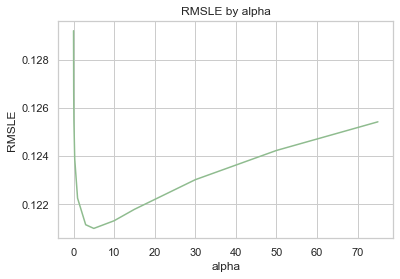

In [85]:
alphas = [0.01, 0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [getRMSLE(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "RMSLE by alpha",color='DarkSeaGreen')
plt.xlabel("alpha")
plt.ylabel("RMSLE")

Best alpha: 5.0
RMSLE: 0.12100255762689485


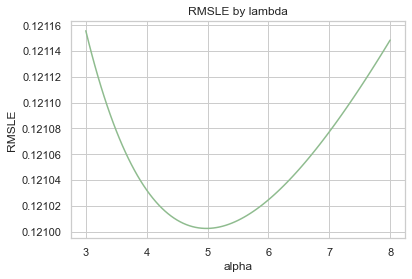

In [86]:
alpha_list = list(np.linspace(3, 8, 101))

rmsle_ridge = [getRMSLE(Ridge(alpha=alpha_)) for alpha_ in alpha_list]
rmsle_ridge = pd.Series(rmsle_ridge, index=alpha_list)

rmsle_ridge.plot(title="RMSLE by lambda",color='DarkSeaGreen')
plt.xlabel("alpha")
plt.ylabel("RMSLE")

print("Best alpha:", rmsle_ridge.idxmin())
print("RMSLE:", rmsle_ridge.min())

In [87]:
ridge = Ridge(alpha=rmsle_ridge.idxmin())
model_ridge = ridge.fit(Z_train, y)

In [88]:
#R2
print(cross_val_score(model_ridge, X_train_80, y_train_80, cv=5).mean())
print(model_ridge.score(X_train_80, y_train_80))
print(model_ridge.score(X_test_20, y_test_20))

0.9194211775136013
0.9367950898030459
0.9070165554505331


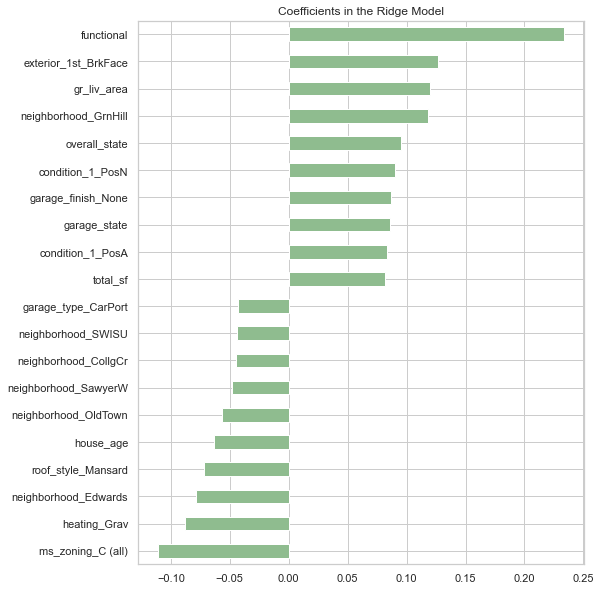

In [89]:
#Important coefficients Ridge model chose
ridge_coef = pd.Series(model_ridge.coef_, index = Z_train.columns)
ridge_imp_coef = pd.concat([ridge_coef.sort_values().head(10),
                     ridge_coef.sort_values().tail(10)])
plt.rcParams['figure.figsize'] = (8.0, 10.0)
ridge_imp_coef.plot(kind = "barh",color='DarkSeaGreen')
plt.title("Coefficients in the Ridge Model");

### Lasso Regression

In [90]:
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]

Text(0, 0.5, 'RMSLE')

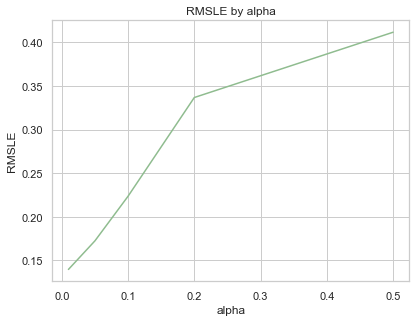

In [91]:
alphas = [1e-2, 0.05, 0.1, 0.2, 0.5]
cv_lasso = [getRMSLE(Lasso(alpha = alpha,max_iter=1e5)).mean() 
            for alpha in alphas]
cv_lasso = pd.Series(cv_lasso, index = alphas)
cv_lasso.plot(title = "RMSLE by alpha",color='DarkSeaGreen')
plt.xlabel("alpha")
plt.ylabel("RMSLE")

Text(0, 0.5, 'RMSLE')

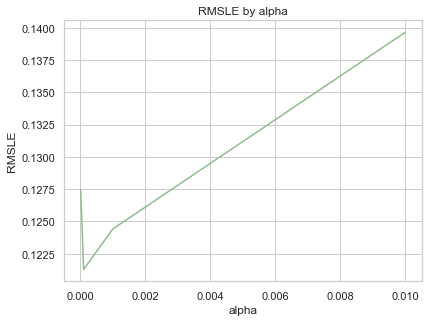

In [92]:
# Seems like the min RMSLE lies on the left side
alphas = [1e-5, 1e-4, 1e-3, 1e-2]
cv_lasso = [getRMSLE(Lasso(alpha = alpha,max_iter=1e5)).mean() 
            for alpha in alphas]
cv_lasso = pd.Series(cv_lasso, index = alphas)
cv_lasso.plot(title = "RMSLE by alpha",color='DarkSeaGreen')
plt.xlabel("alpha")
plt.ylabel("RMSLE")

Best alpha: 0.00018800000000000002
RMSLE: 0.12076388710235605


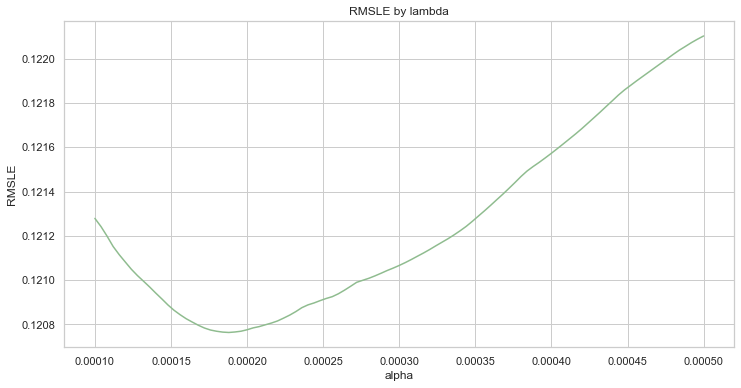

In [93]:
alpha_list = list(np.linspace(0.0001, 0.0005, 101))
rmsle_lasso = [
    getRMSLE(Lasso(alpha=alpha_, max_iter=1e5)) for alpha_ in alpha_list
]
rmsle_lasso = pd.Series(rmsle_lasso, index=alpha_list)

plt.figure(figsize=(12, 6))
rmsle_lasso.plot(title="RMSLE by lambda",color='DarkSeaGreen')
plt.xlabel("alpha")
plt.ylabel("RMSLE")

print("Best alpha:", rmsle_lasso.idxmin())
print("RMSLE:", rmsle_lasso.min())

In [94]:
lasso = Lasso(alpha=rmsle_lasso.idxmin(), max_iter=1e5)
model_lasso = lasso.fit(Z_train, y)

In [95]:
#R2
print(cross_val_score(model_lasso, X_train_80, y_train_80, cv=5).mean())
print(model_lasso.score(X_train_80, y_train_80))
print(model_lasso.score(X_test_20, y_test_20))

0.9192381082840878
0.9353639998220851
0.9038576336242721


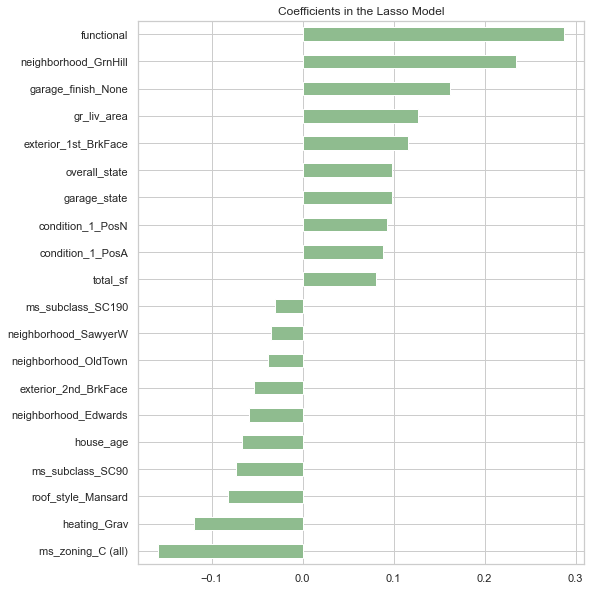

In [96]:
#Important coefficients Lasso model chose
lasso_coef = pd.Series(model_lasso.coef_, index = Z_train.columns)
lasso_imp_coef = pd.concat([lasso_coef.sort_values().head(10),
                     lasso_coef.sort_values().tail(10)])
plt.rcParams['figure.figsize'] = (8.0, 10.0)
lasso_imp_coef.plot(kind = "barh",color='DarkSeaGreen')
plt.title("Coefficients in the Lasso Model");

In [97]:
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]

### Elastic Net

Text(0, 0.5, 'RMSLE')

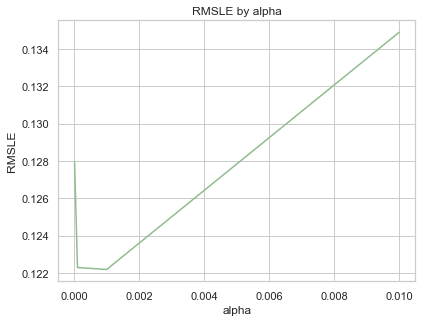

In [98]:
alphas = [1e-5, 1e-4, 1e-3, 1e-2]
cv_lasso = [getRMSLE(ElasticNet(alpha = alpha,max_iter=1e5)).mean() 
            for alpha in alphas]
cv_lasso = pd.Series(cv_lasso, index = alphas)
cv_lasso.plot(title = "RMSLE by alpha",color='DarkSeaGreen')
plt.xlabel("alpha")
plt.ylabel("RMSLE")

Best lambda: 0.00036599999999999995
RMSLE: 0.12076169560547834


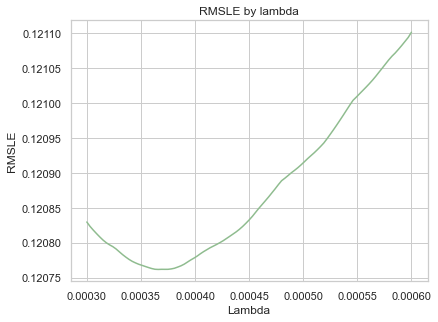

In [99]:
alpha_list = list(np.linspace(0.0003, 0.0006, 101))
rmsle_elasticnet = [
    getRMSLE(ElasticNet(alpha=alpha_)) for alpha_ in alpha_list
]
rmsle_elasticnet = pd.Series(rmsle_elasticnet, index=alpha_list)

rmsle_elasticnet.plot(title="RMSLE by lambda",color='DarkSeaGreen')
plt.xlabel("Lambda")
plt.ylabel("RMSLE")

print("Best lambda:", rmsle_elasticnet.idxmin())
print("RMSLE:", rmsle_elasticnet.min())

In [100]:
enet = ElasticNet(alpha=rmsle_lasso.idxmin(), max_iter=1e5)
model_enet = enet.fit(Z_train, y)

In [101]:
#R2
print(cross_val_score(model_enet, X_train_80, y_train_80, cv=5).mean())
print(model_enet.score(X_train_80, y_train_80))
print(model_enet.score(X_test_20, y_test_20))

0.9185087784465586
0.9376946651886631
0.9076585075004612


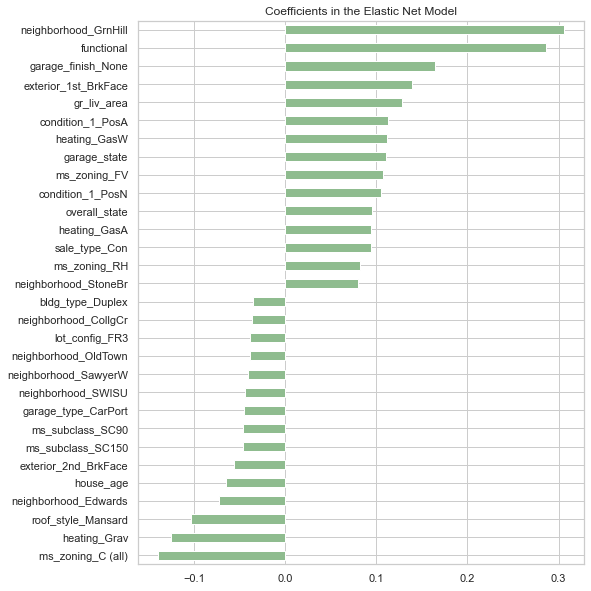

In [102]:
#Important coefficients Enet model chose
enet_coef = pd.Series(model_enet.coef_, index = Z_train.columns)
enet_imp_coef = pd.concat([enet_coef.sort_values().head(15),
                     enet_coef.sort_values().tail(15)])
plt.rcParams['figure.figsize'] = (8.0, 10.0)
enet_imp_coef.plot(kind = "barh",color='DarkSeaGreen')
plt.title("Coefficients in the Elastic Net Model");

## Evaluation of models

In [103]:
summary_table = pd.DataFrame(np.array([['Null Model', dr.score(X_train_80, y_train_80), 
                                        dr.score(X_test_20, y_test_20),cross_val_score(dr, X_train_80, y_train_80, cv=5).mean(),
                                        'NA'], 
                                       ['Linear Regression', lr.score(X_train_80, y_train_80), 
                                        lr.score(X_test_20, y_test_20),cross_val_score(lr, X_train_80, y_train_80, cv=5).mean(),
                                        'NA'],
                                       ['Ridge Regression', model_ridge.score(X_train_80, y_train_80), 
                                        model_ridge.score(X_test_20, y_test_20),
                                        cross_val_score(model_ridge, X_train_80, y_train_80, cv=5).mean(),
                                        rmsle_ridge.min()],
                                       ['Lasso Regression', model_lasso.score(X_train_80, y_train_80), 
                                        model_lasso.score(X_test_20, y_test_20),cross_val_score(model_lasso, X_train_80, y_train_80, cv=5).mean(),
                                        rmsle_lasso.min()],
                                       ['Elastic Net Regression', model_enet.score(X_train_80, y_train_80), 
                                        model_enet.score(X_test_20, y_test_20),cross_val_score(model_enet, X_train_80, y_train_80, cv=5).mean(),
                                        rmsle_elasticnet.min()]]),
                   columns=['model','R2_train','R2_test','cross_val','RMSLE'])

In [104]:
summary_table

model            R2_train                 R2_test  \
0              Null Model                 0.0  -0.0011067747957018703   
1       Linear Regression  0.9450919056707622  -2.111550395760495e+20   
2        Ridge Regression  0.9367950898030459      0.9070165554505331   
3        Lasso Regression  0.9353639998220851      0.9038576336242721   
4  Elastic Net Regression  0.9376946651886631      0.9076585075004612   

                cross_val                RMSLE  
0   -0.006235970005366243                   NA  
1  -1.722268974679759e+20                   NA  
2      0.9194211775136013  0.12100255762689485  
3      0.9192381082840878  0.12076388710235605  
4      0.9185087784465586  0.12076169560547834

All 3 regularisation models worked pretty well with close predicted values to the actual values. The RMSLE score of the **Elastic Net** was better than the other models. The test score and cross-val R2 score for Elastic Net was also the closest.

### Chosen model: Elastic Net

In [105]:
my_model = model_enet
my_model.fit(Z_train, y)
predictions = my_model.predict(Z_test)
final_predictions = np.exp(predictions)
output = pd.DataFrame({'Id': test_df.index, 'SalePrice': final_predictions})
output.to_csv('./datasets/submission.csv', index=False) # for submission to Kaggle

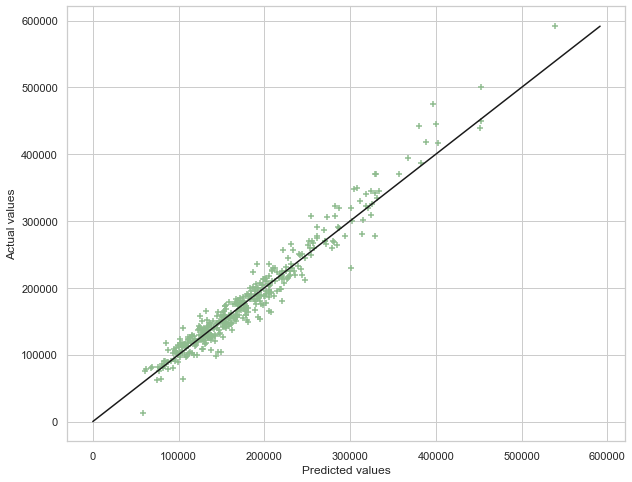

In [106]:
#Generates a list of the model's predictions for the test bloc
preds = enet.predict(X_test_20)

#Plots predicted values against actual values in the train/test split.
plt.figure(figsize=(10,8))
plt.scatter(np.exp(preds),np.exp(y_test_20),marker = '+',color='DarkSeaGreen')
plt.xlabel('Predicted values')
plt.ylabel('Actual values')

#Plots x=y line
plt.plot([0,np.max(np.exp(y_test_20))],[0,np.max(np.exp(y_test_20))], c = 'k');

The model's predictions seems to be pretty spot on compared to the actual values :D

Text(0.5, 1.0, 'Residuals')

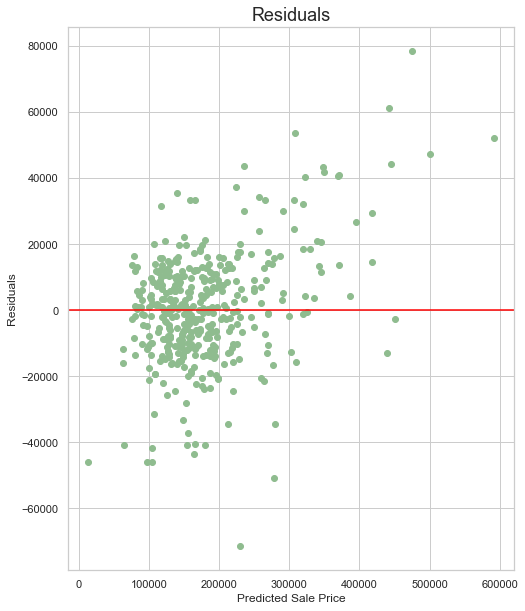

In [107]:
plt.scatter(np.exp(y_test_20),((np.exp(y_test_20))-(np.exp(preds))),color='DarkSeaGreen')
plt.axhline(y=0, c='red')
plt.xlabel('Predicted Sale Price', fontsize=12)
plt.ylabel('Residuals', fontsize=12)
plt.title('Residuals', fontsize=18)

The residuals are somewhat equally distributed but it can be seen that the model cannot predict well for sale prices more than $300k as it fans out beyond that point. This suggests further tailoring of the features to further reduce this variance.

# Conclusion & Recommendations

In [108]:
enet_res = pd.Series(enet_imp_coef, name='coefficients')
enet_res.index.name = 'features'
enet_res = enet_res.reset_index()
enet_res['% change in y'] = (np.exp(enet_res['coefficients'])-1)*100
# As numerical features also underwent a log transformation, the percentage change should be calculated differently
# https://data.library.virginia.edu/interpreting-log-transformations-in-a-linear-model/
# Ignore the % changes for ground living area and functional
# 1% increase in ground living area = 0.1279% in sale price
# 5% increase in ground living area = 0.6288% in sale price
enet_res

features  coefficients  % change in y
0      ms_zoning_C (all)     -0.139651     -13.033809
1           heating_Grav     -0.125377     -11.783540
2     roof_style_Mansard     -0.103830      -9.862123
3   neighborhood_Edwards     -0.072301      -6.974888
4              house_age     -0.065534      -6.343282
5   exterior_2nd_BrkFace     -0.055823      -5.429379
6      ms_subclass_SC150     -0.046731      -4.565631
7       ms_subclass_SC90     -0.046239      -4.518603
8    garage_type_CarPort     -0.044847      -4.385615
9     neighborhood_SWISU     -0.044583      -4.360380
10  neighborhood_SawyerW     -0.040583      -3.977056
11  neighborhood_OldTown     -0.038394      -3.766621
12        lot_config_FR3     -0.038336      -3.761043
13  neighborhood_CollgCr     -0.036909      -3.623623
14      bldg_type_Duplex     -0.035206      -3.459319
15  neighborhood_StoneBr      0.080100       8.339569
16          ms_zoning_RH      0.082426       8.591816
17         sale_type_Con      0.093854       9.839933
18          heating_GasA      0.094679       9.930610
19         overall_state      0.095204       9.988290
20      condition_1_PosN      0.104905      11.060564
21          ms_zoning_FV      0.107092      11.303655
22          garage_state      0.110436      11.676433
23          heating_GasW      0.111632      11.810129
24      condition_1_PosA      0.112691      11.928579
25           gr_liv_area      0.128481      13.710038
26  exterior_1st_BrkFace      0.139153      14.930029
27    garage_finish_None      0.164251      17.851016
28            functional      0.286499      33.175706
29  neighborhood_GrnHill      0.305790      35.769695

Based on the chosen model's coefficients, we can interpret that:
1. Neighbourhoods such as Edwards and South & West of Iowa State University decrease sale price by 6.97% and 4.36% (corroborates the EDA on neighbourhood). Hence, when dealing with houses in that neighbourhood, spendings has to be done more prudently.
2. Houses near parks/greenbelts would result in ~11% increase in sale price
3. Brick Face exteriors results in a 14.9% increase in sale price
4. Mansard roof styles should be avoided where possible (results in a 9.86% decrease in sale price)
5. Increasing the group living area by building annexes may be risky as a 1% increase in living area would result in 0.127% increase in sale price but further cost-benefit analysis is required to determine if there would be profits in doing so.

Currently, the model is useful in picking prime locations or neighbourhoods which require more prudent planning. The next steps to build on profits from renovation would require a companion analysis on labour and material costs to predict profitability of the renovations.

**Caveats**
1. This model is based on 2006-2010 data but market trends and residential architecture trends can fluctuate across the years. More data collection would be required to factor in market trends and the team can further build upon the modelling.
2. Further statistical analysis could be conducted to further fix multicollinearity and increase precision of coefficients especially when it affects cash flows in the thousands. The model focused on bivariate correlations and can be expanded to analysing the variance inflation factor.

## ANNEX

### Data Dictinary

|Feature|Description|Data Type|
|---|---|---|
|Id|Observation number|Discrete|
|PID|Parcel identification number|Nominal|
|MS SubClass|Identifies the type of dwelling involved in the sale.|Nominal|
|MS Zoning|Identifies the general zoning classification of the sale.|Nominal|
|Lot Frontage|Linear feet of street connected to property|Continuous|
|Lot Area|Lot size in square feet|Continuous|
|Street|Type of road access to property|Nominal|
|Alley|Type of alley access to property|Nominal|
|Lot Shape|General shape of property|Ordinal|
|Land Contour|Flatness of the property|Nominal|
|Utilities|Type of utilities available|Ordinal|
|Lot Config|Lot configuration|Nominal|
|Land Slope|Slope of property|Ordinal|
|Neighborhood|Physical locations within Ames city limits|Nominal|
|Condition 1|Proximity to various conditions|Nominal|
|Condition 2|Proximity to various conditions (if more than one is present)|Nominal|
|Bldg Type|Type of dwelling|Nominal|
|House Style|Style of dwelling|Nominal|
|Overall Qual|Rates the overall material and finish of the house|Ordinal|
|Overall Cond|Rates the overall condition of the house|Ordinal|
|Year Built|Original construction date|Discrete|
|Year Remod/Add|Remodel date (same as construction date if no remodeling or additions)|Discrete|
|Roof Style|Type of roof|Nominal|
|Roof Matl|Roof material|Nominal|
|Exterior 1st|Exterior covering on house|Nominal|
|Exterior 2nd|Exterior covering on house (if more than one material)|Nominal|
|Mas Vnr Type|Masonry veneer type|Nominal|
|Mas Vnr Area|Masonry veneer area in square feet|Continuous|
|Exter Qual|Evaluates the quality of the material on the exterior|Ordinal|
|Exter Cond|Evaluates the present condition of the material on the exterior|Ordinal|
|Foundation|Type of foundation|Nominal|
|Bsmt Qual|Evaluates the height of the basement|Ordinal|
|Bsmt Cond|Evaluates the general condition of the basement|Ordinal|
|Bsmt Exposure|Refers to walkout or garden level walls|Ordinal|
|BsmtFin Type 1|Rating of basement finished area|Ordinal|
|BsmtFin SF 1|Type 1 finished square feet|Continuous|
|BsmtFin Type 2|Rating of basement finished area (if multiple types)|Ordinal|
|BsmtFin SF 2|Type 2 finished square feet|Continuous|
|Bsmt Unf SF|Unfinished square feet of basement area|Continuous|
|Total Bsmt SF|Total square feet of basement area|Continuous|
|Heating|Type of heating|Nominal|
|Heating QC|Heating quality and condition|Ordinal|
|Central Air|Central air conditioning|Nominal|
|Electrical|Electrical system|Ordinal|
|1st Flr SF|First Floor square feet|Continuous|
|2nd Flr SF|Second floor square feet|Continuous|
|Low Qual Fin SF|Low quality finished square feet (all floors)|Continuous|
|Gr Liv Area|Above grade (ground) living area square feet|Continuous|
|Bsmt Full Bath|Basement full bathrooms|Discrete|
|Bsmt Half Bath|Basement half bathrooms|Discrete|
|Full Bath|Full bathrooms above grade|Discrete|
|Half Bath|Half baths above grade|Discrete|
|Bedroom AbvGr|Bedrooms above grade (does NOT include basement bedrooms)|Discrete|
|Kitchen AbvGr|Kitchens above grade|Discrete|
|Kitchen Qual|Kitchen quality|Ordinal|
|TotRms AbvGrd|Total rooms above grade (does not include bathrooms)|Discrete|
|Functional|Home functionality (Assume typical unless deductions are warranted)|Ordinal|
|Fireplaces|Number of fireplaces|Discrete|
|Fireplace Qu|Fireplace quality|Ordinal|
|Garage Type|Garage location|Nominal|
|Garage Yr Blt|Year garage was built|Discrete|
|Garage Finish|Interior finish of the garage|Ordinal|
|Garage Cars|Size of garage in car capacity|Discrete|
|Garage Area|Size of garage in square feet|Continuous|
|Garage Qual|Garage quality|Ordinal|
|Garage Cond|Garage condition|Ordinal|
|Paved Drive|Paved driveway|Ordinal|
|Wood Deck SF|Wood deck area in square feet|Continuous|
|Open Porch SF|Open porch area in square feet|Continuous|
|Enclosed Porch|Enclosed porch area in square feet|Continuous|
|3Ssn Porch|Three season porch area in square feet|Continuous|
|Screen Porch|Screen porch area in square feet|Continuous|
|Pool Area|Pool area in square feet|Continuous|
|Pool QC|Pool quality|Ordinal|
|Fence|Fence quality|Ordinal|
|Misc Feature|Miscellaneous feature not covered in other categories|Nominal|
|Misc Val|$Value of miscellaneous feature|Continuous|
|Mo Sold|Month Sold (MM)|Discrete|
|Yr Sold|Year Sold (YYYY)|Discrete|
|Sale Type|Type of sale|Nominal|
|Sale Condition|Condition of sale|Nominal|
|SalePrice|Sale price $$|Continuous|![image.png](attachment:image.png)